In [1]:
import os
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.3.0-posix-seh-rt_v5-rev0\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
from matplotlib import rc
rc('figure', figsize=(15, 5))
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor

In [3]:
def create_submission_df(pred):
    new_df = by_month.loc[:,('shop_id','item_id')]
    new_df = sales_test.merge(new_df, on = ['shop_id', 'item_id'], how = 'inner').drop(['ID'], axis = 1)
    new_df['target'] = pred
    new_df = sales_test.merge(new_df, on = ['shop_id', 'item_id'], how = 'left')
    new_df['target'].fillna(0,inplace=True)
    return(new_df)

In [4]:
def error(pred, act):
    return(np.sqrt(np.sum(np.square(np.subtract(act,pred)))/sales_test.shape[0]))

In [78]:
def create_submission_file(pred, name):
    new_df = create_submission_df(pred)
    new_df = new_df.loc[:,('ID', 'target')]
    new_df.columns = ['ID', 'item_cnt_month']
    new_df.loc[:,('ID','item_cnt_month')].to_csv('submissions_time_series/'+name+'.csv',index = False)

In [6]:
def expanding_mean_encode(x_tr_index, tr_index, var, times = 5):
    encoded_feature = [0]*by_month.shape[0]
    for i in range(times):
        rows = np.arange(0,by_month.shape[0])
        x_tr = by_month.loc[rows, x_tr_index]
        cum_sum = by_month.groupby(var)[tr_index].cumsum()
        cum_count = by_month.groupby(var).cumcount() + 1
        x_tr[str(var)+'_enc'] = cum_sum/cum_count
        x_tr[str(var)+'_enc'].fillna(by_month[tr_index].mean(), inplace = True)
        encoded_feature += x_tr[str(var)+'_enc']
    x_tr[str(var)+'_enc'] = encoded_feature/times
    return(x_tr)

In [7]:
def max_sum_average(tr_index_init = 0, tr_index = 33, max_num = 1, sum_num = 12, ave_num = 1, expand = True, 
                    var = 'item_category_id'):
    months = np.arange(0,34)
    x_tr_index = ['item_id', 'shop_id', 'item_category_id']
    x_tr_pred_index = x_tr_index.copy()
    x_tr_index.extend(np.arange(tr_index_init,tr_index).tolist())
    x_tr_pred_index.extend(np.arange(tr_index_init+1,tr_index+1).tolist())
    if max_num>0:
        by_month_shopid_max = by_month.groupby(var).max().loc[:,months].add_suffix('_max')
        req_cols = np.arange((tr_index-max_num),(tr_index))
        req_cols = [str(i)+'_max' for i in req_cols]
        x_tr_max = by_month[x_tr_index].join(by_month_shopid_max.loc[:,req_cols], 
                                         on = var)
        
        req_cols = np.arange((tr_index-max_num+1),(tr_index+1))
        req_cols = [str(i)+'_max' for i in req_cols]    
        x_tr_pred_max = by_month[x_tr_pred_index].join(by_month_shopid_max.loc[:,req_cols], 
                                                       on = var)
        
    else:
        x_tr_max = by_month.loc[:,x_tr_index]
        x_tr_pred_max = by_month.loc[:,x_tr_pred_index]

    if sum_num>0:
        by_month_shopid_sum = by_month.groupby(var).sum(axis = 0).loc[:,months]
        by_month_cols_sum = by_month_shopid_sum.loc[by_month[var].values,(tr_index-sum_num):(tr_index-1)]
        by_month_cols_sum = by_month_cols_sum.reset_index().drop(var, axis = 1).add_suffix('_sum')
        x_tr_max_sum = x_tr_max.join(by_month_cols_sum)
        
        by_month_cols_sum = by_month_shopid_sum.loc[by_month[var].values,:].loc[:,(tr_index-sum_num+1):(tr_index)]
        by_month_cols_sum = by_month_cols_sum.reset_index().drop(var, axis = 1).add_suffix('_sum')
        x_tr_pred_max_sum = x_tr_pred_max.join(by_month_cols_sum)
        
    else:
        x_tr_max_sum = x_tr_max
        x_tr_pred_max_sum = x_tr_pred_max
     
    if ave_num>0:
        by_month_shopid_item_count = by_month.groupby(var)['item_id'].count()
        by_month_shopid_average = by_month.groupby(var).sum(axis = 0).divide(by_month_shopid_item_count, axis = 0).loc[:,months]
        by_month_cols_average = by_month_shopid_average.loc[by_month[var].values,(tr_index-ave_num):(tr_index-1)].reset_index(
        ).drop(var,axis = 1).add_suffix('_ave')
        x_tr_max_sum_average = x_tr_max_sum.join(by_month_cols_average)
        
        by_month_cols_average = by_month_shopid_average.loc[by_month[var].values,(tr_index-ave_num+1):(tr_index)].reset_index(
        ).drop(var, axis = 1).add_suffix('_ave')
        x_tr_pred_max_sum_average = x_tr_pred_max_sum.join(by_month_cols_average)
        
    else:
        x_tr_max_sum_average = x_tr_max_sum
        x_tr_pred_max_sum_average = x_tr_pred_max_sum
    
    if expand:
        x_tr_max_sum_average['item_id_enc'] = expanding_mean_encode(x_tr_index, tr_index, 'item_id',times = 1)['item_id_enc']
        x_tr_max_sum_average['shop_id_enc'] = expanding_mean_encode(x_tr_index, tr_index, 'shop_id',times = 1)['shop_id_enc']
        
        x_tr_pred_max_sum_average['item_id_enc'] = x_tr_max_sum_average['item_id_enc']
        x_tr_pred_max_sum_average['shop_id_enc'] = x_tr_max_sum_average['shop_id_enc']
        
        x_tr_max_sum_average = x_tr_max_sum_average.drop(['shop_id', 'item_id'], axis = 1)
    
    
    x_tr = x_tr_max_sum_average.values
    x_tr_pred_max_sum_average = sales_test.merge(x_tr_pred_max_sum_average, on = ['item_id','shop_id'], 
                                                 how = 'inner').drop(['ID'], axis = 1)
   
    if expand: 
        x_tr_pred_max_sum_average=x_tr_pred_max_sum_average.drop(['item_id', 'shop_id'], axis = 1)
    x_tr_pred = x_tr_pred_max_sum_average.values
    
    return(x_tr_max_sum_average, x_tr, x_tr_pred_max_sum_average, x_tr_pred)

In [8]:
def create_y(tr_index):
    val = sales_test.merge(by_month.loc[:,['item_id','shop_id',tr_index+1]], 
                           on = ['shop_id', 'item_id']).drop(['ID','shop_id', 'item_id'], axis = 1)
    return(val)

In [9]:
sales_train = pd.read_csv(r'sales_train_v2.csv')
items = pd.read_csv(r'items.csv')
item_categories = pd.read_csv(r'item_categories.csv')
shops = pd.read_csv(r'shops.csv')
sales_test = pd.read_csv(r'test.csv')

In [10]:
sales_test = sales_test.loc[:, ['ID', 'item_id', 'shop_id']]

In [11]:
months = np.arange(0,34)

In [12]:
by_month = pd.pivot_table(sales_train, index= ('item_id','shop_id'), values='item_cnt_day', columns='date_block_num',
                          aggfunc = sum)
by_month[by_month.isnull()] = 0
by_month = by_month.reset_index()
by_month = by_month.join(items.loc[:,('item_id','item_category_id')].set_index('item_id'), on='item_id')

In [13]:
by_month_test_inner = sales_test.merge(by_month, on = ['shop_id', 'item_id'], 
                                                 how = 'inner').drop(['ID'], axis = 1)

In [278]:
by_month.columns

Index([         'item_id',          'shop_id',                  0,
                        1,                  2,                  3,
                        4,                  5,                  6,
                        7,                  8,                  9,
                       10,                 11,                 12,
                       13,                 14,                 15,
                       16,                 17,                 18,
                       19,                 20,                 21,
                       22,                 23,                 24,
                       25,                 26,                 27,
                       28,                 29,                 30,
                       31,                 32,                 33,
       'item_category_id'],
      dtype='object')

In [604]:
tr_index = 32
tr_index_init = tr_index-32

In [605]:
[x_tr_max_sum_average, x_tr, x_tr_pred_max_sum_average, x_tr_pred] = max_sum_average(tr_index_init=tr_index_init, 
                                                                                     tr_index=tr_index, max_num=1, 
                                                                                     sum_num=1, ave_num=1, expand = False,
                                                                                    var = 'item_category_id')

In [606]:
x_te = by_month[tr_index]
x_te_pred = create_y(tr_index)

In [608]:
cat_features = [0,1,2]
cat = CatBoostRegressor(learning_rate=0.1, iterations = 3000, l2_leaf_reg = 50, depth = 2, one_hot_max_size=2, metric_period=30,
                       rsm = 1)
cat.fit(x_tr_max_sum_average, x_te, cat_features = cat_features, eval_set=(x_tr_pred_max_sum_average,x_te_pred), 
        early_stopping_rounds=200)

0:	learn: 4.9010888	test: 7.6623204	best: 7.6623204 (0)	total: 237ms	remaining: 11m 51s
30:	learn: 4.5044146	test: 7.1867017	best: 7.1867017 (30)	total: 5.54s	remaining: 8m 51s
60:	learn: 4.2722665	test: 6.9326126	best: 6.9326126 (60)	total: 10.8s	remaining: 8m 41s
90:	learn: 4.0578822	test: 6.8252697	best: 6.8252697 (90)	total: 15.9s	remaining: 8m 29s
120:	learn: 3.9694567	test: 6.7550327	best: 6.7550327 (120)	total: 21.1s	remaining: 8m 21s
150:	learn: 3.8565526	test: 6.7031793	best: 6.7031793 (150)	total: 26.4s	remaining: 8m 17s
180:	learn: 3.7771001	test: 6.7067933	best: 6.7031793 (150)	total: 31.7s	remaining: 8m 13s
210:	learn: 3.7242790	test: 6.6755711	best: 6.6755711 (210)	total: 36.8s	remaining: 8m 6s
240:	learn: 3.6587455	test: 6.6793326	best: 6.6755711 (210)	total: 42.3s	remaining: 8m 3s
270:	learn: 3.5641726	test: 6.6688543	best: 6.6688543 (270)	total: 47.5s	remaining: 7m 58s
300:	learn: 3.4972004	test: 6.6582763	best: 6.6582763 (300)	total: 52.7s	remaining: 7m 52s
330:	learn

In [609]:
np.sqrt(mean_squared_error(x_te, cat.predict(x_tr)))

3.3290758206797033

In [610]:
np.sqrt(mean_squared_error(create_y(tr_index), cat.predict(x_tr_pred)))

6.65179740156523

In [611]:
error(create_y(tr_index).values[:,0], cat.predict(x_tr_pred))

4.797109945217082

### Try adding the correlation features shop_id wise

In [612]:
by_month_shopid = by_month.groupby('shop_id').sum(axis=0).loc[:,months]

In [613]:
by_month_shopid_corr = by_month_shopid.T.corr().add_suffix('_corr')

In [614]:
x_tr_withcorr_shop = x_tr_max_sum_average.join(by_month_shopid_corr, on = 'shop_id', rsuffix='_corr', how = 'left')

In [615]:
x_tr_pred_withcorr_shop = x_tr_pred_max_sum_average.join(by_month_shopid_corr, on = 'shop_id', rsuffix='_corr', how = 'left')

In [629]:
cat_features = [0,1,2]
cat_withcorr_shop = CatBoostRegressor(learning_rate=0.1, iterations = 3000, l2_leaf_reg = 50, depth = 2, one_hot_max_size=2, metric_period=30,
                       rsm = 1)
cat_withcorr_shop.fit(x_tr_withcorr_shop, x_te, cat_features = cat_features, eval_set=(x_tr_pred_withcorr_shop,x_te_pred), 
        early_stopping_rounds=200)

0:	learn: 4.8881169	test: 7.6550738	best: 7.6550738 (0)	total: 390ms	remaining: 19m 30s
30:	learn: 4.3971878	test: 7.1467776	best: 7.1467776 (30)	total: 8.32s	remaining: 13m 16s
60:	learn: 4.2298047	test: 6.8490487	best: 6.8490487 (60)	total: 15.5s	remaining: 12m 28s
90:	learn: 4.0784767	test: 6.7040485	best: 6.7040485 (90)	total: 22.6s	remaining: 12m 2s
120:	learn: 3.9386487	test: 6.5775478	best: 6.5775478 (120)	total: 30s	remaining: 11m 54s
150:	learn: 3.8632756	test: 6.5007762	best: 6.5007762 (150)	total: 37.5s	remaining: 11m 47s
180:	learn: 3.7632873	test: 6.4626357	best: 6.4626357 (180)	total: 44.7s	remaining: 11m 36s
210:	learn: 3.6586187	test: 6.4664674	best: 6.4626357 (180)	total: 51.8s	remaining: 11m 25s
240:	learn: 3.5849059	test: 6.4482128	best: 6.4482128 (240)	total: 59.2s	remaining: 11m 17s
270:	learn: 3.4996063	test: 6.4145838	best: 6.4145838 (270)	total: 1m 6s	remaining: 11m 14s
300:	learn: 3.4301071	test: 6.4030325	best: 6.4030325 (300)	total: 1m 16s	remaining: 11m 23s


### submitting the predictions

In [665]:
test_index = 33
test_index_init = test_index-32

In [666]:
[_, _, x_tr_test_max_sum_average, x_test] = max_sum_average(tr_index_init=test_index_init, 
                                                                                     tr_index=test_index, max_num=1, 
                                                                                     sum_num=1, ave_num=1, expand = False,
                                                                                    var = 'item_category_id')

In [667]:
x_tr_test_withcorr_shop = x_tr_test_max_sum_average.join(by_month_shopid_corr, on = 'shop_id', rsuffix='_corr', how = 'left')

In [668]:
x_tr_test_withcorr_shop.shape

(111404, 98)

In [669]:
x_tr_pred_withcorr_shop.shape

(111404, 98)

In [670]:
cat_features = [0,1,2]
cat_test_withcorr_shop = CatBoostRegressor(learning_rate=0.1, iterations = 3000, l2_leaf_reg = 50, depth = 2, one_hot_max_size=2, metric_period=30,
                       rsm = 1)
cat_test_withcorr_shop.fit(x_tr_pred_withcorr_shop, x_te_pred, cat_features = cat_features, early_stopping_rounds=200)

0:	learn: 7.6553055	total: 104ms	remaining: 5m 11s
30:	learn: 6.9582202	total: 2.9s	remaining: 4m 37s
60:	learn: 6.5298388	total: 5.18s	remaining: 4m 9s
90:	learn: 6.1563620	total: 7.31s	remaining: 3m 53s
120:	learn: 5.8090769	total: 9.82s	remaining: 3m 53s
150:	learn: 5.5010236	total: 12.5s	remaining: 3m 55s
180:	learn: 5.2091950	total: 15.5s	remaining: 4m 2s
210:	learn: 4.9221955	total: 18.2s	remaining: 4m 1s
240:	learn: 4.6569746	total: 20.6s	remaining: 3m 56s
270:	learn: 4.4487748	total: 23.2s	remaining: 3m 53s
300:	learn: 4.2227970	total: 26s	remaining: 3m 53s
330:	learn: 4.0143574	total: 28.5s	remaining: 3m 49s
360:	learn: 3.8439010	total: 30.8s	remaining: 3m 44s
390:	learn: 3.6822993	total: 33s	remaining: 3m 40s
420:	learn: 3.5332332	total: 35.4s	remaining: 3m 37s
450:	learn: 3.3933951	total: 37.9s	remaining: 3m 34s
480:	learn: 3.2578973	total: 40s	remaining: 3m 29s
510:	learn: 3.1478935	total: 42.2s	remaining: 3m 25s
540:	learn: 3.0350651	total: 44.4s	remaining: 3m 21s
570:	lea

In [673]:
create_submission_file(cat_test_withcorr_shop.predict(x_tr_test_withcorr_shop.values), 'catboost_withcorr_shop')

### Try adding correlations item category wise

In [620]:
by_month_itcat = by_month.groupby('item_category_id').sum(axis=0).loc[:,months]

In [621]:
by_month_itcat_corr = by_month_itcat.T.corr().add_suffix('_corr')

In [624]:
x_tr_withcorr_itcat = x_tr_max_sum_average.join(by_month_itcat_corr, on = 'item_category_id', rsuffix='_corr', how = 'left')

In [625]:
x_tr_pred_withcorr_itcat = x_tr_pred_max_sum_average.join(by_month_itcat_corr, on = 'item_category_id', rsuffix='_corr', how = 'left')

In [672]:
cat_features = [0,1,2]
cat_withcorr_itcat = CatBoostRegressor(learning_rate=0.1, iterations = 3000, l2_leaf_reg = 50, depth = 2, one_hot_max_size=2, metric_period=30,
                       rsm = 1)
cat_withcorr_itcat.fit(x_tr_withcorr_itcat, x_te, cat_features = cat_features, eval_set=(x_tr_pred_withcorr_itcat,x_te_pred), 
        early_stopping_rounds=200)

0:	learn: 4.9104911	test: 7.6747897	best: 7.6747897 (0)	total: 399ms	remaining: 19m 57s
30:	learn: 4.4124509	test: 7.2094599	best: 7.2094599 (30)	total: 9.04s	remaining: 14m 25s
60:	learn: 4.0608731	test: 7.0362039	best: 7.0362039 (60)	total: 17.8s	remaining: 14m 15s
90:	learn: 3.8506137	test: 6.9802933	best: 6.9802933 (90)	total: 26.7s	remaining: 14m 13s
120:	learn: 3.7459059	test: 6.8726190	best: 6.8726190 (120)	total: 35.4s	remaining: 14m 1s
150:	learn: 3.6422667	test: 6.8218195	best: 6.8218195 (150)	total: 45.7s	remaining: 14m 21s
180:	learn: 3.5408587	test: 6.7767220	best: 6.7767220 (180)	total: 57.5s	remaining: 14m 55s
210:	learn: 3.4420984	test: 6.7452844	best: 6.7452844 (210)	total: 1m 9s	remaining: 15m 23s
240:	learn: 3.3725548	test: 6.7245684	best: 6.7245684 (240)	total: 1m 20s	remaining: 15m 25s
270:	learn: 3.2585761	test: 6.6835039	best: 6.6835039 (270)	total: 1m 30s	remaining: 15m 10s
300:	learn: 3.1816877	test: 6.6749763	best: 6.6749763 (300)	total: 1m 39s	remaining: 14m 

In [674]:
cat_withcorr_shop.get_feature_importance(prettified=True)

[(b'31', 53.991733193782345),
 (b'31_sum', 10.5630126937897),
 (b'31_ave', 9.810966653450311),
 (b'item_category_id', 6.18491971730894),
 (b'9_corr', 5.180579401396448),
 (b'31_max', 5.109673928279533),
 (b'12_corr', 3.9666954892931496),
 (b'shop_id', 1.5273186346149237),
 (b'55_corr', 1.1341248337388763),
 (b'20_corr', 1.126624521559361),
 (b'30', 0.37944319136945004),
 (b'38_corr', 0.18095340836601953),
 (b'28', 0.15256675235000697),
 (b'26', 0.12969316813486473),
 (b'23', 0.11078132289440959),
 (b'36_corr', 0.10248421871416853),
 (b'27', 0.09149040249028227),
 (b'17', 0.046820900888430245),
 (b'2_corr', 0.03480276265296653),
 (b'16', 0.03386785339791644),
 (b'29', 0.023256434976515198),
 (b'5_corr', 0.02114287039193538),
 (b'17_corr', 0.015470980783135569),
 (b'11', 0.01199275385539307),
 (b'3_corr', 0.006906386560847795),
 (b'24_corr', 0.006149010896195491),
 (b'18', 0.00588221453994745),
 (b'35_corr', 0.005752841891867826),
 (b'6', 0.005306399515684348),
 (b'14', 0.005290944949378

In [675]:
cat_withcorr_itcat.get_feature_importance(prettified=True)

[(b'31', 48.64479243418118),
 (b'8_corr', 26.175617086374675),
 (b'item_id', 7.182169297938716),
 (b'item_category_id', 3.404689947896284),
 (b'28', 2.868807014831374),
 (b'27', 2.6971074474208208),
 (b'80_corr', 2.446043989495416),
 (b'shop_id', 1.6658163462778213),
 (b'30', 1.655848722906164),
 (b'69_corr', 1.4047406236311804),
 (b'65_corr', 0.9949915641206921),
 (b'26', 0.5347603802120063),
 (b'31_max', 0.056122660462924884),
 (b'15_corr', 0.048537462222035345),
 (b'29', 0.04753283228013133),
 (b'39_corr', 0.03622125504117038),
 (b'16', 0.033603629999215845),
 (b'14', 0.027437199348278457),
 (b'12_corr', 0.017963804435714742),
 (b'17_corr', 0.014340577926283071),
 (b'11', 0.010010444258499757),
 (b'10', 0.0071778602046836445),
 (b'17', 0.004100971499320564),
 (b'20', 0.004010903861068896),
 (b'29_corr', 0.0030160928931576812),
 (b'71_corr', 0.0020414657119134302),
 (b'25', 0.001518869836452988),
 (b'9', 0.0014607186173195086),
 (b'19', 0.0012252212287879867),
 (b'6', 0.0012216310404

### Try combining both type of correlations

In [647]:
x_tr_withcorr_shop_itcat = x_tr_withcorr_shop.join(by_month_itcat_corr, on = 'item_category_id', lsuffix='_shop', how = 'left')
x_tr_pred_withcorr_shop_itcat = x_tr_pred_withcorr_shop.join(by_month_itcat_corr, on = 'item_category_id', lsuffix='_shop', how = 'left')

In [653]:
cat_features = [0,1,2]
cat_withcorr_shop_itcat = CatBoostRegressor(learning_rate=0.1, iterations = 3000, l2_leaf_reg = 50, depth = 2, one_hot_max_size=2, metric_period=30,
                       rsm = 1)
cat_withcorr_shop_itcat.fit(x_tr_withcorr_shop_itcat, x_te, cat_features = cat_features, 
                       eval_set=(x_tr_pred_withcorr_shop_itcat,x_te_pred), early_stopping_rounds=200)

0:	learn: 4.8853705	test: 7.6464519	best: 7.6464519 (0)	total: 490ms	remaining: 24m 30s
30:	learn: 4.3672556	test: 7.1361152	best: 7.1361152 (30)	total: 13.5s	remaining: 21m 29s
60:	learn: 4.1103982	test: 6.8565214	best: 6.8565214 (60)	total: 30.5s	remaining: 24m 28s
90:	learn: 3.9056803	test: 6.7152778	best: 6.7152778 (90)	total: 43.9s	remaining: 23m 22s
120:	learn: 3.7217169	test: 6.6562075	best: 6.6562075 (120)	total: 58.3s	remaining: 23m 6s
150:	learn: 3.5966612	test: 6.5727021	best: 6.5727021 (150)	total: 1m 14s	remaining: 23m 30s
180:	learn: 3.4109643	test: 6.5007288	best: 6.5007288 (180)	total: 1m 29s	remaining: 23m 10s
210:	learn: 3.2655733	test: 6.4687584	best: 6.4687584 (210)	total: 1m 43s	remaining: 22m 46s
240:	learn: 3.1791564	test: 6.4569995	best: 6.4569995 (240)	total: 1m 57s	remaining: 22m 21s
270:	learn: 3.1191686	test: 6.4279508	best: 6.4279508 (270)	total: 2m 9s	remaining: 21m 44s
300:	learn: 3.0348640	test: 6.4085171	best: 6.4085171 (300)	total: 2m 21s	remaining: 21

### Submit predictions

In [654]:
test_index = 33
test_index_init = test_index-32

In [655]:
[_, _, x_tr_test_max_sum_average, x_test] = max_sum_average(tr_index_init=test_index_init, 
                                                                                     tr_index=test_index, max_num=1, 
                                                                                     sum_num=1, ave_num=1, expand = False,
                                                                                    var = 'item_category_id')

In [657]:
x_tr_test_withcorr_shop = x_tr_test_max_sum_average.join(by_month_shopid_corr, on = 'shop_id', rsuffix='_corr', how = 'left')

In [658]:
x_tr_test_withcorr_shop_itcat = x_tr_test_withcorr_shop.join(by_month_itcat_corr, on = 'item_category_id', 
                                                             lsuffix='_shop', how = 'left')

In [659]:
x_tr_test_withcorr_shop_itcat.shape

(111404, 182)

In [661]:
x_tr_pred_withcorr_shop_itcat.shape

(111404, 182)

In [663]:
cat_features = [0,1,2]
cat_test_withcorr_shop_itcat = CatBoostRegressor(learning_rate=0.05, iterations = 3000, l2_leaf_reg = 50, depth = 2, one_hot_max_size=2, metric_period=30,
                       rsm = 1)
cat_test_withcorr_shop_itcat.fit(x_tr_pred_withcorr_shop_itcat, x_te_pred, cat_features = cat_features, early_stopping_rounds=200)

0:	learn: 7.6907535	total: 160ms	remaining: 7m 58s
30:	learn: 7.2169514	total: 3.59s	remaining: 5m 43s
60:	learn: 6.9639562	total: 7.39s	remaining: 5m 56s
90:	learn: 6.7386291	total: 11.2s	remaining: 5m 56s
120:	learn: 6.5300216	total: 14.5s	remaining: 5m 45s
150:	learn: 6.3319203	total: 18.4s	remaining: 5m 46s
180:	learn: 6.1470801	total: 22.1s	remaining: 5m 44s
210:	learn: 5.9898247	total: 25.5s	remaining: 5m 37s
240:	learn: 5.8231072	total: 28.9s	remaining: 5m 31s
270:	learn: 5.6596711	total: 32.5s	remaining: 5m 27s
300:	learn: 5.5072397	total: 35.8s	remaining: 5m 21s
330:	learn: 5.3604214	total: 39.1s	remaining: 5m 15s
360:	learn: 5.2162466	total: 42.8s	remaining: 5m 12s
390:	learn: 5.0768808	total: 47.2s	remaining: 5m 15s
420:	learn: 4.9417996	total: 51.1s	remaining: 5m 13s
450:	learn: 4.8188108	total: 54.7s	remaining: 5m 9s
480:	learn: 4.6940999	total: 57.9s	remaining: 5m 3s
510:	learn: 4.5834413	total: 1m 1s	remaining: 4m 58s
540:	learn: 4.4617557	total: 1m 5s	remaining: 4m 55s


In [664]:
create_submission_file(cat_test_withcorr.predict(x_tr_test_withcorr_shop_itcat.values), 'catboost_withcorr_shop_itcat')

### Try combining shop_id and item_categorical_id to one feature

In [682]:
x_tr_shop_itcat = x_tr_withcorr_shop_itcat.copy()
x_tr_shop_itcat['shop_itcat'] = x_tr_shop_itcat.apply(lambda x: str(x['shop_id'])+'_'+str(x['item_category_id']), axis = 1)

In [683]:
x_tr_pred_shop_itcat = x_tr_pred_withcorr_shop_itcat.copy()
x_tr_pred_shop_itcat['shop_itcat'] = x_tr_pred_shop_itcat.apply(lambda x: str(x['shop_id'])+'_'+str(x['item_category_id']), axis = 1)

In [685]:
from sklearn.preprocessing import LabelEncoder

In [686]:
le = LabelEncoder()

In [688]:
x_tr_shop_itcat['shop_itcat'] = le.fit_transform(x_tr_shop_itcat['shop_itcat'])

In [689]:
x_tr_pred_shop_itcat['shop_itcat'] = le.transform(x_tr_pred_shop_itcat['shop_itcat'])

In [692]:
cat_features = [0,1,2,x_tr_shop_itcat.shape[1]-1]
cat_shop_itcat = CatBoostRegressor(learning_rate=0.1, iterations = 3000, l2_leaf_reg = 50, depth = 2, one_hot_max_size=2, metric_period=30,
                       rsm = 1)
cat_shop_itcat.fit(x_tr_shop_itcat, x_te, cat_features = cat_features, eval_set=(x_tr_pred_shop_itcat,x_te_pred), 
        early_stopping_rounds=200)

0:	learn: 4.8881169	test: 7.6550738	best: 7.6550738 (0)	total: 659ms	remaining: 32m 55s
30:	learn: 4.5036896	test: 7.1335425	best: 7.1335425 (30)	total: 17.7s	remaining: 28m 12s
60:	learn: 4.2391887	test: 6.8684719	best: 6.8684719 (60)	total: 30.8s	remaining: 24m 45s
90:	learn: 3.9531957	test: 6.7678909	best: 6.7678909 (90)	total: 44.1s	remaining: 23m 30s
120:	learn: 3.8788285	test: 6.5836859	best: 6.5836859 (120)	total: 57.2s	remaining: 22m 40s
150:	learn: 3.7270528	test: 6.5211539	best: 6.5211539 (150)	total: 1m 10s	remaining: 22m 11s
180:	learn: 3.5743723	test: 6.5089502	best: 6.5089502 (180)	total: 1m 23s	remaining: 21m 43s
210:	learn: 3.5159272	test: 6.4921595	best: 6.4921595 (210)	total: 1m 36s	remaining: 21m 18s
240:	learn: 3.4405283	test: 6.5060300	best: 6.4921595 (210)	total: 1m 49s	remaining: 20m 57s
270:	learn: 3.3589417	test: 6.5017319	best: 6.4921595 (210)	total: 2m 3s	remaining: 20m 41s
300:	learn: 3.2286863	test: 6.4652387	best: 6.4652387 (300)	total: 2m 16s	remaining: 2

In [693]:
cat_shop_itcat.get_feature_importance(prettified=True)

[(b'31', 50.56534870760683),
 (b'8_corr', 26.057717418420285),
 (b'item_id', 3.773717690971117),
 (b'shop_itcat', 3.6487285340988787),
 (b'80_corr', 2.904774222403205),
 (b'30', 1.714642793740169),
 (b'20_corr_shop', 1.5493070146053034),
 (b'28', 1.4902266230595338),
 (b'27', 1.4549704077006729),
 (b'65_corr', 1.4533398319942359),
 (b'9_corr_shop', 1.1864156741588925),
 (b'38_corr_shop', 0.8978952123193192),
 (b'12_corr_shop', 0.8358195456837704),
 (b'item_category_id', 0.6562331085786071),
 (b'24_corr_shop', 0.49492565066461774),
 (b'31_max', 0.26268848636951886),
 (b'55_corr_shop', 0.1561321485476131),
 (b'36_corr_shop', 0.13543669957596516),
 (b'69_corr', 0.1100516179720048),
 (b'26', 0.09503386706085012),
 (b'31_ave', 0.09050807241392345),
 (b'shop_id', 0.04978151344206267),
 (b'39_corr', 0.04660343772930741),
 (b'16', 0.041365462242829394),
 (b'23_corr_shop', 0.03259633061216987),
 (b'5_corr_shop', 0.029322995033681),
 (b'70_corr', 0.026062721952050602),
 (b'31_sum', 0.02362331914

### Don't  Bother: Try combining shop_id and item_categorical_id to one feature and drop these two

In [329]:
x_tr_shop_itcat.drop(['shop_id', 'item_category_id'], axis = 1, inplace = True)

In [331]:
x_tr_pred_shop_itcat.drop(['shop_id', 'item_category_id'], axis = 1, inplace = True)

In [332]:
cat_features = [0,x_tr_shop_itcat.shape[1]-1]
cat_shop_itcat_w = CatBoostRegressor(learning_rate=0.1, iterations = 3000, l2_leaf_reg = 50, depth = 2, one_hot_max_size=2, metric_period=30,
                       rsm = 1)
cat_shop_itcat_w.fit(x_tr_shop_itcat.values, x_te, cat_features = cat_features, eval_set=(x_tr_pred_shop_itcat.values,x_te_pred), 
        early_stopping_rounds=200)

0:	learn: 4.8697458	test: 7.6763236	best: 7.6763236 (0)	total: 173ms	remaining: 8m 39s
30:	learn: 4.4663563	test: 7.1495485	best: 7.1495485 (30)	total: 3.88s	remaining: 6m 11s
60:	learn: 4.2662655	test: 7.0171713	best: 7.0171713 (60)	total: 7.49s	remaining: 6m
90:	learn: 4.1472701	test: 6.8992359	best: 6.8992359 (90)	total: 11s	remaining: 5m 52s
120:	learn: 4.0315121	test: 6.8169737	best: 6.8169737 (120)	total: 14.8s	remaining: 5m 52s
150:	learn: 3.9402193	test: 6.8197644	best: 6.8169737 (120)	total: 18.4s	remaining: 5m 47s
180:	learn: 3.8356446	test: 6.8512492	best: 6.8169737 (120)	total: 22s	remaining: 5m 43s
210:	learn: 3.7915156	test: 6.8497660	best: 6.8169737 (120)	total: 25.6s	remaining: 5m 37s
240:	learn: 3.7478842	test: 6.8456032	best: 6.8169737 (120)	total: 29.1s	remaining: 5m 32s
270:	learn: 3.6630097	test: 6.8553191	best: 6.8169737 (120)	total: 32.6s	remaining: 5m 28s
300:	learn: 3.5925725	test: 6.8640400	best: 6.8169737 (120)	total: 36.2s	remaining: 5m 24s
330:	learn: 3.536

### Count the frequency of each shop, category, item

In [694]:
item_freq = by_month.groupby('item_id').size().rename('item_freq')

In [695]:
x_tr_withcorr_itemfreq = x_tr_withcorr_shop_itcat.join(item_freq, on = 'item_id')

In [696]:
x_tr_pred_withcorr_itemfreq = x_tr_pred_withcorr_shop_itcat.join(item_freq, on = 'item_id')

In [698]:
cat_features = [0,1,2]
cat_withcorr_itemfreq = CatBoostRegressor(learning_rate=0.1, iterations = 3000, l2_leaf_reg = 50, depth = 2, 
                                          one_hot_max_size=2, metric_period=30, rsm = 1)
cat_withcorr_itemfreq.fit(x_tr_withcorr_itemfreq, x_te, cat_features = cat_features, eval_set=(x_tr_pred_withcorr_itemfreq,
                                                                                         x_te_pred), early_stopping_rounds=200)

0:	learn: 4.9101268	test: 7.6800696	best: 7.6800696 (0)	total: 563ms	remaining: 28m 8s
30:	learn: 4.3581339	test: 7.1187510	best: 7.1187510 (30)	total: 13.3s	remaining: 21m 13s
60:	learn: 4.1284862	test: 6.8550113	best: 6.8550113 (60)	total: 25.8s	remaining: 20m 42s
90:	learn: 3.8698811	test: 6.6677616	best: 6.6677616 (90)	total: 38.4s	remaining: 20m 27s
120:	learn: 3.7434048	test: 6.5546343	best: 6.5546343 (120)	total: 50.7s	remaining: 20m 5s
150:	learn: 3.6432603	test: 6.4608528	best: 6.4608528 (150)	total: 1m 3s	remaining: 20m
180:	learn: 3.5187640	test: 6.4311931	best: 6.4311931 (180)	total: 1m 16s	remaining: 19m 49s
210:	learn: 3.3660213	test: 6.4007068	best: 6.4007068 (210)	total: 1m 29s	remaining: 19m 43s
240:	learn: 3.2528750	test: 6.3369633	best: 6.3369633 (240)	total: 1m 42s	remaining: 19m 37s
270:	learn: 3.1754293	test: 6.3202299	best: 6.3202299 (270)	total: 1m 55s	remaining: 19m 26s
300:	learn: 3.0755460	test: 6.2962606	best: 6.2962606 (300)	total: 2m 8s	remaining: 19m 15s


### dont bother

In [464]:
imp_features = []
for i in cat_withcorr_shop_itemfreq.get_feature_importance(prettified=True):
    if i[1]>0:
        imp_features.append(i[0])

In [412]:
imp_cols = ['item_category_id', 'shop_id', 'item_id', 'item_freq', '31',28,'55_corr','31_ave','31_max','31_sum', 30]
imp_cols_pred = ['item_category_id', 'shop_id', 'item_id', 'item_freq', '32',29,'55_corr','32_ave','32_max','32_sum', 31]

In [414]:
cat_features = [0,1,2]
cat = CatBoostRegressor(learning_rate=0.1, iterations = 3000, l2_leaf_reg = 50, depth = 2, one_hot_max_size=2, metric_period=30,
                       rsm = 1)
cat.fit(x_tr_withcorr_shop_itemfreq[imp_cols], x_te, cat_features = cat_features, 
        eval_set=(x_tr_pred_withcorr_shop_itemfreq[imp_cols_pred], x_te_pred), early_stopping_rounds=200)

0:	learn: 4.8881169	test: 7.6550738	best: 7.6550738 (0)	total: 175ms	remaining: 8m 45s
30:	learn: 4.4333523	test: 7.0596466	best: 7.0596466 (30)	total: 3.76s	remaining: 6m
60:	learn: 4.2034746	test: 6.7977378	best: 6.7977378 (60)	total: 7.05s	remaining: 5m 39s
90:	learn: 4.0708432	test: 6.5992324	best: 6.5992324 (90)	total: 10.4s	remaining: 5m 32s
120:	learn: 3.9702679	test: 6.4923687	best: 6.4923687 (120)	total: 13.7s	remaining: 5m 26s
150:	learn: 3.9234750	test: 6.4118107	best: 6.4118107 (150)	total: 17.1s	remaining: 5m 22s
180:	learn: 3.8042599	test: 6.4020424	best: 6.4020424 (180)	total: 20.4s	remaining: 5m 17s
210:	learn: 3.7308949	test: 6.3671854	best: 6.3671854 (210)	total: 23.6s	remaining: 5m 12s
240:	learn: 3.6271415	test: 6.3570832	best: 6.3570832 (240)	total: 27s	remaining: 5m 8s
270:	learn: 3.5764911	test: 6.3347878	best: 6.3347878 (270)	total: 30.3s	remaining: 5m 5s
300:	learn: 3.5140693	test: 6.3151306	best: 6.3151306 (300)	total: 33.7s	remaining: 5m 2s
330:	learn: 3.4612

In [699]:
shop_freq = by_month.groupby('shop_id').size().rename('shop_freq')

In [421]:
x_tr_impcols = x_tr_withcorr_shop_itemfreq[imp_cols].join(shop_freq, on = 'shop_id')
x_tr_pred_impcols = x_tr_pred_withcorr_shop_itemfreq[imp_cols_pred].join(shop_freq, on = 'shop_id')

In [426]:
cat_features = [0,1,2]
cat = CatBoostRegressor(learning_rate=0.1, iterations = 3000, l2_leaf_reg = 50, depth = 2, one_hot_max_size=2, metric_period=30,
                       rsm = 1)
cat.fit(x_tr_impcols, x_te, cat_features = cat_features, 
        eval_set=(x_tr_pred_impcols, x_te_pred), early_stopping_rounds=200)

0:	learn: 4.8789569	test: 7.6359262	best: 7.6359262 (0)	total: 203ms	remaining: 10m 10s
30:	learn: 4.4591836	test: 7.1074162	best: 7.1074162 (30)	total: 3.88s	remaining: 6m 11s
60:	learn: 4.2420474	test: 6.8348507	best: 6.8348507 (60)	total: 7.61s	remaining: 6m 6s
90:	learn: 4.0888574	test: 6.6813878	best: 6.6813878 (90)	total: 11.5s	remaining: 6m 7s
120:	learn: 3.9787368	test: 6.6242668	best: 6.6242668 (120)	total: 15.4s	remaining: 6m 5s
150:	learn: 3.8959716	test: 6.5785893	best: 6.5785893 (150)	total: 19.2s	remaining: 6m 2s
180:	learn: 3.8171234	test: 6.5730528	best: 6.5730528 (180)	total: 23.4s	remaining: 6m 3s
210:	learn: 3.7647442	test: 6.5396311	best: 6.5396311 (210)	total: 26.9s	remaining: 5m 55s
240:	learn: 3.6835071	test: 6.4975025	best: 6.4975025 (240)	total: 30.3s	remaining: 5m 47s
270:	learn: 3.6170854	test: 6.5014444	best: 6.4975025 (240)	total: 33.9s	remaining: 5m 41s
300:	learn: 3.5463119	test: 6.5090407	best: 6.4975025 (240)	total: 37.8s	remaining: 5m 38s
330:	learn: 3

In [430]:
itcat_freq = by_month.groupby('item_category_id').size().rename('itcat_freq')

In [565]:
x_tr_impcols = x_tr_withcorr_shop_itemfreq[imp_cols].join(itcat_freq, on = 'item_category_id')
x_tr_pred_impcols = x_tr_pred_withcorr_shop_itemfreq[imp_cols_pred].join(itcat_freq, on = 'item_category_id')

In [566]:
cat_features = [0,1,2]
cat_impcols = CatBoostRegressor(learning_rate=0.1, iterations = 3000, l2_leaf_reg = 50, depth = 2, one_hot_max_size=2, metric_period=30,
                       rsm = 1)
cat_impcols.fit(x_tr_impcols, x_te, cat_features = cat_features, 
        eval_set=(x_tr_pred_impcols, x_te_pred), early_stopping_rounds=400)

0:	learn: 4.8720570	test: 7.6494562	best: 7.6494562 (0)	total: 218ms	remaining: 10m 52s
30:	learn: 4.4218006	test: 7.0189631	best: 7.0189631 (30)	total: 4.36s	remaining: 6m 57s
60:	learn: 4.2392058	test: 6.7353961	best: 6.7353961 (60)	total: 8.03s	remaining: 6m 26s
90:	learn: 4.0733755	test: 6.5460893	best: 6.5460893 (90)	total: 11.6s	remaining: 6m 9s
120:	learn: 3.9632333	test: 6.4551529	best: 6.4551529 (120)	total: 15s	remaining: 5m 57s
150:	learn: 3.8888001	test: 6.3979749	best: 6.3979749 (150)	total: 18.6s	remaining: 5m 50s
180:	learn: 3.8042138	test: 6.3603763	best: 6.3603763 (180)	total: 22.1s	remaining: 5m 44s
210:	learn: 3.7361377	test: 6.3602955	best: 6.3602955 (210)	total: 25.5s	remaining: 5m 37s
240:	learn: 3.6847458	test: 6.3127558	best: 6.3127558 (240)	total: 28.9s	remaining: 5m 31s
270:	learn: 3.6076554	test: 6.2988181	best: 6.2988181 (270)	total: 32.6s	remaining: 5m 28s
300:	learn: 3.5179143	test: 6.2864525	best: 6.2864525 (300)	total: 36.3s	remaining: 5m 25s
330:	learn:

In [567]:
cat_impcols.get_feature_importance(prettified=True)

[(b'31', 51.309143027908114),
 (b'item_freq', 14.34276951019305),
 (b'31_ave', 10.872910521782476),
 (b'item_category_id', 9.24537690973219),
 (b'31_sum', 4.74895614945247),
 (b'shop_id', 3.0468312498480636),
 (b'31_max', 2.9193096988464005),
 (b'item_id', 1.386971756177792),
 (b'28', 1.0770044117129172),
 (b'30', 0.9624485137691511),
 (b'55_corr', 0.07640932767230824),
 (b'itcat_freq', 0.011868922905076415)]

### Just trying xgboost for a while 

In [727]:
xgbalg = XGBRegressor(learning_rate = 0.1, n_estimators = 1000, max_depth = 10, min_child_weight = 10, gamma = 0,
                    subsample = 1, colsample_bytree=1, seed = 24, silent = True)

In [728]:
xgtrain = xgb.DMatrix(x_tr_withcorr_itemfreq.values, x_te)
xgtest = xgb.DMatrix(x_tr_pred_withcorr_itemfreq.values, x_te_pred)
xgbresults = xgb.train(xgbalg.get_xgb_params(), xgtrain, num_boost_round=3000, early_stopping_rounds = 200, verbose_eval=10,
                      evals = [(xgtest, 'test')])

[0]	test-rmse:7.59172
Will train until test-rmse hasn't improved in 200 rounds.
[10]	test-rmse:6.76527
[20]	test-rmse:6.77879
[30]	test-rmse:6.82032
[40]	test-rmse:6.86551
[50]	test-rmse:6.86427
[60]	test-rmse:6.88632
[70]	test-rmse:6.90594
[80]	test-rmse:6.90239
[90]	test-rmse:6.90139
[100]	test-rmse:6.89872
[110]	test-rmse:6.90643
[120]	test-rmse:6.91177
[130]	test-rmse:6.9224
[140]	test-rmse:6.91658
[150]	test-rmse:6.92281
[160]	test-rmse:6.92187
[170]	test-rmse:6.91442
[180]	test-rmse:6.91236
[190]	test-rmse:6.91938
[200]	test-rmse:6.91859
[210]	test-rmse:6.91563
Stopping. Best iteration:
[14]	test-rmse:6.74974



### Back to CatBoost

In [700]:
x_tr_withcorr_itemitcatfreq = x_tr_withcorr_itemfreq.join(itcat_freq, on = 'item_category_id')
x_tr_pred_withcorr_itemitcatfreq = x_tr_pred_withcorr_itemfreq.join(itcat_freq, on = 'item_category_id')

In [702]:
cat_features = [0,1,2]
cat_withcorr_itemitcatfreq = CatBoostRegressor(learning_rate=0.05, iterations = 3000, l2_leaf_reg = 50, depth = 2, one_hot_max_size=2, metric_period=30,
                       rsm = 1)
cat_withcorr_itemitcatfreq.fit(x_tr_withcorr_itemitcatfreq, x_te, cat_features = cat_features, 
        eval_set=(x_tr_pred_withcorr_itemitcatfreq, x_te_pred), early_stopping_rounds=200)

0:	learn: 4.9042399	test: 7.6769169	best: 7.6769169 (0)	total: 539ms	remaining: 26m 57s
30:	learn: 4.5679797	test: 7.3244089	best: 7.3244089 (30)	total: 14.5s	remaining: 23m 13s
60:	learn: 4.4467391	test: 7.1112641	best: 7.1112641 (60)	total: 28.1s	remaining: 22m 36s
90:	learn: 4.3231125	test: 6.9250313	best: 6.9250313 (90)	total: 41.1s	remaining: 21m 53s
120:	learn: 4.1824597	test: 6.8094536	best: 6.8094536 (120)	total: 53.7s	remaining: 21m 17s
150:	learn: 4.0731085	test: 6.6986033	best: 6.6986033 (150)	total: 1m 6s	remaining: 20m 48s
180:	learn: 3.9938499	test: 6.6199770	best: 6.6199770 (180)	total: 1m 18s	remaining: 20m 27s
210:	learn: 3.9139482	test: 6.5528165	best: 6.5528165 (210)	total: 1m 31s	remaining: 20m 7s
240:	learn: 3.8410587	test: 6.4959026	best: 6.4959026 (240)	total: 1m 44s	remaining: 19m 50s
270:	learn: 3.7342144	test: 6.4503830	best: 6.4503830 (270)	total: 1m 56s	remaining: 19m 30s
300:	learn: 3.6376402	test: 6.4041890	best: 6.4041890 (300)	total: 2m 8s	remaining: 19m

In [704]:
cat_withcorr_itemitcatfreq.get_feature_importance(prettified=True)

[(b'31', 45.85558217689948),
 (b'8_corr', 25.22961720578992),
 (b'item_category_id', 5.167962931289514),
 (b'item_freq', 4.615102267743628),
 (b'item_id', 4.040948470742728),
 (b'31_ave', 2.556411744871067),
 (b'27', 1.8141083644754443),
 (b'12_corr_shop', 1.725032698815108),
 (b'28', 1.644154557481493),
 (b'30', 1.4563544582531733),
 (b'80_corr', 1.2945709169592816),
 (b'69_corr', 1.089269924650029),
 (b'38_corr_shop', 0.8623939505674256),
 (b'9_corr_shop', 0.6813748980860812),
 (b'65_corr', 0.5912830655670591),
 (b'36_corr_shop', 0.3284119749089111),
 (b'20_corr_shop', 0.2872225178314489),
 (b'shop_id', 0.2512138777586099),
 (b'23_corr', 0.06794791661284105),
 (b'39_corr', 0.06632381036998719),
 (b'47_corr_shop', 0.05728265817827191),
 (b'16', 0.047964605933192316),
 (b'26', 0.03406002692864378),
 (b'31_max', 0.027468757759630855),
 (b'25_corr_shop', 0.02401381205010246),
 (b'29', 0.018820928236181353),
 (b'12_corr', 0.018203712595120092),
 (b'83_corr', 0.014208732267792694),
 (b'22_

### Submit the solutions

In [707]:
x_tr_withcorr_itemitcatfreq.shape

(424124, 184)

In [708]:
test_index = 33
test_index_init = test_index-32

In [710]:
[_, _, x_tr_test_max_sum_average, x_test] = max_sum_average(tr_index_init=test_index_init, 
                                                                                     tr_index=test_index, max_num=1, 
                                                                                     sum_num=1, ave_num=1, expand = False,
                                                                                    var = 'item_category_id')

In [711]:
x_tr_test_withcorr = x_tr_test_max_sum_average.join(by_month_shopid_corr, on = 'shop_id', rsuffix='_corr', how = 'left')

In [715]:
x_tr_test_withcorr = x_tr_test_withcorr.join(by_month_itcat_corr, on = 'item_category_id', lsuffix='_shop', how = 'left')

In [716]:
x_tr_test_withcorr_itemfreq = x_tr_test_withcorr.join(item_freq, on = 'item_id')

In [717]:
x_tr_test_withcorr_itemfreq_itcatfreq = x_tr_test_withcorr_itemfreq.join(itcat_freq, on = 'item_category_id')

In [718]:
x_tr_test_withcorr_itemfreq_itcatfreq.shape

(111404, 184)

In [724]:
cat_features = [0,1,2]
cat_test_withcorr_freq = CatBoostRegressor(learning_rate=0.1, iterations = 6000, l2_leaf_reg = 50, depth = 2, one_hot_max_size=2, 
                                           metric_period=300, rsm = 1)
cat_test_withcorr_freq.fit(x_tr_pred_withcorr_itemitcatfreq, x_te_pred, cat_features = cat_features, early_stopping_rounds=200)

0:	learn: 7.6484824	total: 127ms	remaining: 12m 39s
300:	learn: 4.2641048	total: 31.3s	remaining: 9m 52s
600:	learn: 2.8812520	total: 1m 3s	remaining: 9m 28s
900:	learn: 2.2592069	total: 1m 35s	remaining: 9m 2s
1200:	learn: 1.9467661	total: 2m 8s	remaining: 8m 31s
1500:	learn: 1.7797715	total: 2m 39s	remaining: 7m 59s
1800:	learn: 1.6968860	total: 3m 12s	remaining: 7m 29s
2100:	learn: 1.6411700	total: 3m 47s	remaining: 7m 1s
2400:	learn: 1.6079258	total: 4m 20s	remaining: 6m 29s
2700:	learn: 1.5791048	total: 4m 52s	remaining: 5m 57s
3000:	learn: 1.5465970	total: 5m 25s	remaining: 5m 25s
3300:	learn: 1.5228420	total: 5m 57s	remaining: 4m 52s
3600:	learn: 1.4963087	total: 6m 30s	remaining: 4m 19s
3900:	learn: 1.4727993	total: 7m 3s	remaining: 3m 48s
4200:	learn: 1.4453933	total: 7m 37s	remaining: 3m 15s
4500:	learn: 1.4282565	total: 8m 10s	remaining: 2m 43s
4800:	learn: 1.4137484	total: 8m 42s	remaining: 2m 10s
5100:	learn: 1.4051642	total: 9m 15s	remaining: 1m 37s
5400:	learn: 1.3963480

In [725]:
create_submission_file(cat_test_withcorr_freq.predict(x_tr_test_withcorr_itemfreq_itcatfreq.values), 'catboost_withcorr_freq')

### Adding shop frequency

In [729]:
x_tr_withcorr_itemshopfreq = x_tr_withcorr_itemfreq.join(shop_freq, on = 'shop_id')
x_tr_pred_withcorr_itemshopfreq = x_tr_pred_withcorr_itemfreq.join(shop_freq, on = 'shop_id')

In [731]:
cat_features = [0,1,2]
cat_withcorr_itemshopfreq = CatBoostRegressor(learning_rate=0.05, iterations = 3000, l2_leaf_reg = 50, depth = 2, one_hot_max_size=2, metric_period=30,
                       rsm = 1)
cat_withcorr_itemshopfreq.fit(x_tr_withcorr_itemshopfreq, x_te, cat_features = cat_features, 
        eval_set=(x_tr_pred_withcorr_itemshopfreq, x_te_pred), early_stopping_rounds=200)

0:	learn: 4.9051631	test: 7.6804321	best: 7.6804321 (0)	total: 739ms	remaining: 36m 55s
30:	learn: 4.5830409	test: 7.3326526	best: 7.3326526 (30)	total: 14s	remaining: 22m 20s
60:	learn: 4.4153514	test: 7.1162275	best: 7.1162275 (60)	total: 25.8s	remaining: 20m 44s
90:	learn: 4.2667263	test: 6.9431036	best: 6.9431036 (90)	total: 37.3s	remaining: 19m 52s
120:	learn: 4.1088701	test: 6.8439661	best: 6.8439661 (120)	total: 48.5s	remaining: 19m 15s
150:	learn: 4.0278440	test: 6.7538915	best: 6.7538915 (150)	total: 1m 1s	remaining: 19m 26s
180:	learn: 3.9303636	test: 6.6869351	best: 6.6869351 (180)	total: 1m 14s	remaining: 19m 22s
210:	learn: 3.8554145	test: 6.6281437	best: 6.6281437 (210)	total: 1m 26s	remaining: 18m 59s
240:	learn: 3.7921578	test: 6.5690408	best: 6.5690408 (240)	total: 1m 37s	remaining: 18m 40s
270:	learn: 3.6746681	test: 6.5245188	best: 6.5245188 (270)	total: 1m 49s	remaining: 18m 24s
300:	learn: 3.5906759	test: 6.4945188	best: 6.4945188 (300)	total: 2m 1s	remaining: 18m 

In [732]:
cat_withcorr_itemshopfreq.get_feature_importance(prettified=True)

[(b'31', 46.50072544524777),
 (b'8_corr', 26.561575538456562),
 (b'80_corr', 4.746320244519339),
 (b'item_freq', 4.567338815335511),
 (b'item_id', 3.783345930216185),
 (b'item_category_id', 3.1316097783091768),
 (b'27', 2.1052469015655726),
 (b'28', 1.9785989354025535),
 (b'30', 1.5341631348059832),
 (b'12_corr_shop', 0.86224371687399),
 (b'9_corr_shop', 0.8228870736851697),
 (b'38_corr_shop', 0.6996929398867755),
 (b'65_corr', 0.6862973953039382),
 (b'69_corr', 0.5765488853625479),
 (b'shop_id', 0.35305067410034224),
 (b'36_corr_shop', 0.24190713030491054),
 (b'31_max', 0.22790350369981285),
 (b'24_corr_shop', 0.12310560577972249),
 (b'58_corr_shop', 0.0877695743186595),
 (b'16', 0.04022319230434609),
 (b'20_corr_shop', 0.03832101838395859),
 (b'39_corr', 0.03659456486517592),
 (b'26', 0.02997981324018634),
 (b'20', 0.026114153887790384),
 (b'28_corr_shop', 0.024312045876801202),
 (b'29', 0.018288247745878256),
 (b'17_corr_shop', 0.01704537623266799),
 (b'33_corr_shop', 0.016481507210

### Try adding the price

In [733]:
item_shop_price = sales_train.groupby(['item_id', 'shop_id']).mean()['item_price'].reset_index()

In [734]:
x_tr_price = x_tr_withcorr_itemshopfreq.merge(item_shop_price, on = ['item_id', 'shop_id'])
x_tr_pred_price = x_tr_pred_withcorr_itemshopfreq.merge(item_shop_price, on = ['item_id', 'shop_id'])

In [735]:
cat_features = [0,1,2]
cat_price = CatBoostRegressor(learning_rate=0.05, iterations = 3000, l2_leaf_reg = 50, depth = 2, one_hot_max_size=2, metric_period=30,
                       rsm = 1)
cat_price.fit(x_tr_price, x_te, cat_features = cat_features, 
        eval_set=(x_tr_pred_price, x_te_pred), early_stopping_rounds=200)

0:	learn: 4.9126090	test: 7.6852779	best: 7.6852779 (0)	total: 583ms	remaining: 29m 9s
30:	learn: 4.6227381	test: 7.2996502	best: 7.2996502 (30)	total: 12s	remaining: 19m 7s
60:	learn: 4.3863646	test: 7.1193068	best: 7.1193068 (60)	total: 23s	remaining: 18m 27s
90:	learn: 4.2654389	test: 6.9800625	best: 6.9800625 (90)	total: 34.6s	remaining: 18m 27s
120:	learn: 4.1336902	test: 6.8601485	best: 6.8601485 (120)	total: 46.1s	remaining: 18m 15s
150:	learn: 4.0287791	test: 6.7777169	best: 6.7777169 (150)	total: 57.8s	remaining: 18m 10s
180:	learn: 3.9243832	test: 6.6964646	best: 6.6964646 (180)	total: 1m 9s	remaining: 17m 55s
210:	learn: 3.8776856	test: 6.6269803	best: 6.6269803 (210)	total: 1m 20s	remaining: 17m 44s
240:	learn: 3.8226123	test: 6.5782617	best: 6.5782617 (240)	total: 1m 31s	remaining: 17m 29s
270:	learn: 3.7596289	test: 6.5298314	best: 6.5298314 (270)	total: 1m 42s	remaining: 17m 16s
300:	learn: 3.6882674	test: 6.5008157	best: 6.5008157 (300)	total: 1m 54s	remaining: 17m 2s
3

In [736]:
cat_price.get_feature_importance(prettified=True)

[(b'31', 47.410818248976064),
 (b'8_corr', 27.779627020733066),
 (b'item_id', 4.320686887640838),
 (b'item_freq', 3.7337654665391713),
 (b'27', 3.224633952327581),
 (b'80_corr', 2.939672735452285),
 (b'28', 2.009392548022365),
 (b'30', 1.7503875183625124),
 (b'item_category_id', 1.6962141864341584),
 (b'12_corr_shop', 0.9779916711068429),
 (b'69_corr', 0.9266424096388589),
 (b'31_ave', 0.679722747482972),
 (b'9_corr_shop', 0.6165972767408362),
 (b'shop_id', 0.5538925164748734),
 (b'38_corr_shop', 0.44988854162028474),
 (b'23_corr', 0.20852116423245715),
 (b'65_corr', 0.12834469319867656),
 (b'33_corr_shop', 0.1107165481724153),
 (b'25_corr_shop', 0.08196777441118619),
 (b'55_corr_shop', 0.07949735225679275),
 (b'39_corr', 0.047549348858778755),
 (b'26', 0.04659087034935193),
 (b'16', 0.03918077904757616),
 (b'20_corr_shop', 0.03323833518536734),
 (b'2_corr_shop', 0.01914468338654917),
 (b'31_corr_shop', 0.0176473176387741),
 (b'17_corr_shop', 0.016539599118781202),
 (b'12_corr', 0.0162

### Try adding macd, ewm, sig

In [737]:
ewm26 = by_month.loc[:,months].ewm(span = 26, axis = 1).mean()
ewm12 = by_month.loc[:,months].ewm(span = 12, axis = 1).mean()

In [738]:
macd = ewm26-ewm12

In [739]:
sig = macd.ewm(span = 9, axis = 1).mean()
sig = sig.add_suffix('_sig')

In [740]:
macd = macd.add_suffix('_macd')

In [741]:
ewms = pd.concat([by_month.loc[:,['item_id', 'shop_id']], macd, sig], axis = 1)

In [742]:
ewms.columns

Index(['item_id', 'shop_id', '0_macd', '1_macd', '2_macd', '3_macd', '4_macd',
       '5_macd', '6_macd', '7_macd', '8_macd', '9_macd', '10_macd', '11_macd',
       '12_macd', '13_macd', '14_macd', '15_macd', '16_macd', '17_macd',
       '18_macd', '19_macd', '20_macd', '21_macd', '22_macd', '23_macd',
       '24_macd', '25_macd', '26_macd', '27_macd', '28_macd', '29_macd',
       '30_macd', '31_macd', '32_macd', '33_macd', '0_sig', '1_sig', '2_sig',
       '3_sig', '4_sig', '5_sig', '6_sig', '7_sig', '8_sig', '9_sig', '10_sig',
       '11_sig', '12_sig', '13_sig', '14_sig', '15_sig', '16_sig', '17_sig',
       '18_sig', '19_sig', '20_sig', '21_sig', '22_sig', '23_sig', '24_sig',
       '25_sig', '26_sig', '27_sig', '28_sig', '29_sig', '30_sig', '31_sig',
       '32_sig', '33_sig'],
      dtype='object')

In [743]:
ewms_cols = np.arange(tr_index-12, tr_index)
ewms_suff = ['macd', 'sig']
ewms_cols_suff = ['{}_{}'.format(a,b) for b in ewms_suff for a in ewms_cols]
ewms_train_cols = ['item_id', 'shop_id']
ewms_train_cols.extend(ewms_cols_suff)

In [744]:
ewms_cols_pred = np.arange(tr_index-11, tr_index+1)
ewms_cols_suff_pred = ['{}_{}'.format(a,b) for b in ewms_suff for a in ewms_cols_pred]
ewms_val_cols = ['item_id', 'shop_id']
ewms_val_cols.extend(ewms_cols_suff_pred)

In [745]:
x_tr_ewms = x_tr_price.merge(ewms.loc[:, ewms_train_cols], on = ['item_id', 'shop_id'])
x_tr_pred_ewms = x_tr_pred_price.merge(ewms.loc[:, ewms_val_cols], 
                                       on = ['item_id', 'shop_id'])

In [746]:
cat_features = [0,1,2]
cat_ewms = CatBoostRegressor(learning_rate=0.1, iterations = 3000, l2_leaf_reg = 50, depth = 2, one_hot_max_size=2, metric_period=30,
                       rsm = 1)
cat_ewms.fit(x_tr_ewms, x_te, cat_features = cat_features, 
        eval_set=(x_tr_pred_ewms, x_te_pred), early_stopping_rounds=200)

0:	learn: 4.9016552	test: 7.6622730	best: 7.6622730 (0)	total: 753ms	remaining: 37m 39s
30:	learn: 4.5348305	test: 7.1569297	best: 7.1569297 (30)	total: 13.8s	remaining: 22m 4s
60:	learn: 4.2444996	test: 6.8951535	best: 6.8951535 (60)	total: 27.4s	remaining: 22m
90:	learn: 4.0239642	test: 6.7555166	best: 6.7555166 (90)	total: 40.6s	remaining: 21m 37s
120:	learn: 3.8388190	test: 6.6582747	best: 6.6582747 (120)	total: 53.8s	remaining: 21m 20s
150:	learn: 3.6925708	test: 6.6107329	best: 6.6107329 (150)	total: 1m 6s	remaining: 21m 2s
180:	learn: 3.4806336	test: 6.5658110	best: 6.5658110 (180)	total: 1m 21s	remaining: 21m 1s
210:	learn: 3.3737483	test: 6.5143803	best: 6.5143803 (210)	total: 1m 34s	remaining: 20m 53s
240:	learn: 3.2666079	test: 6.5061968	best: 6.5061968 (240)	total: 1m 48s	remaining: 20m 43s
270:	learn: 3.1645602	test: 6.4727917	best: 6.4727917 (270)	total: 2m 2s	remaining: 20m 30s
300:	learn: 3.0479295	test: 6.4600786	best: 6.4600786 (300)	total: 2m 15s	remaining: 20m 18s
3

In [748]:
cat_ewms.get_feature_importance(prettified=True)

[(b'31', 45.78436249718852),
 (b'8_corr', 25.1515115510902),
 (b'80_corr', 8.95831814400751),
 (b'item_id', 3.023674647282724),
 (b'item_freq', 2.6690633158911283),
 (b'30', 2.2441223398485377),
 (b'28', 1.9488760534709115),
 (b'item_category_id', 1.5616548824442773),
 (b'38_corr_shop', 1.5181485473112248),
 (b'27', 1.1269793070993022),
 (b'69_corr', 0.909522832426601),
 (b'9_corr_shop', 0.7861185796383141),
 (b'36_corr_shop', 0.7104316888180403),
 (b'12_corr_shop', 0.6822036380779136),
 (b'28_macd', 0.6752893130098919),
 (b'29_macd', 0.4979227915028172),
 (b'25_corr', 0.35187970503312843),
 (b'24_corr_shop', 0.31881464101196233),
 (b'20_corr_shop', 0.1842832111836596),
 (b'31_max', 0.16286114829474793),
 (b'27_macd', 0.12417866678766781),
 (b'21_macd', 0.11406468669407006),
 (b'31_ave', 0.06583945799025562),
 (b'26', 0.06514722047982972),
 (b'29', 0.05826327790445754),
 (b'23_corr', 0.054186696836167385),
 (b'39_corr', 0.050742630225522396),
 (b'12_corr', 0.047395889079016436),
 (b'sh

## Let's try multiple validations using random forest

1) Do predictions for 6 months, using all previous months as training <br>
2) Try adding in order --> diff --> correlations --> frequencies --> item price --> ewms

### Baseline model

In [13]:
val_months = np.arange(27,32)

In [14]:
scrt = []
for i in val_months:
    print('validating on month %d' % (i+1))
    [x_tr_df, x_tr, x_tr_pred_df, x_tr_pred] = max_sum_average(tr_index_init=0, tr_index=i, max_num=0, ave_num=0, 
                                                               sum_num=0, expand = False)
    x_te = by_month[i]
    x_te_pred = create_y(i)
    print('shape of train', x_tr_df.shape)
    print('shape of validation', x_tr_pred_df.shape)
    rf = RandomForestRegressor(n_estimators = 50, n_jobs = -1)
    rf.fit(x_tr_df.values, x_te)
    pred = rf.predict(x_tr_pred_df.values)
    scrt.append(error(pred, x_te_pred.values.flatten()))
    print('validation error for month %d = %.5f' %(i, error(pred, x_te_pred.values.flatten())))
print(np.mean(scrt))

validating on month 28
shape of train (424124, 30)
shape of validation (111404, 30)
validation error for month 27 = 3.01986
validating on month 29
shape of train (424124, 31)
shape of validation (111404, 31)
validation error for month 28 = 1.51220
validating on month 30
shape of train (424124, 32)
shape of validation (111404, 32)
validation error for month 29 = 0.94641
validating on month 31
shape of train (424124, 33)
shape of validation (111404, 33)
validation error for month 30 = 1.06904
validating on month 32
shape of train (424124, 34)
shape of validation (111404, 34)
validation error for month 31 = 1.55113
1.619728093042624


In [783]:
[x_tr_df, x_tr, x_tr_pred_df, x_tr_pred] = max_sum_average(tr_index_init=0, tr_index=32, max_num=0, ave_num=0, 
                                                               sum_num=0, expand = False)
x_te = by_month[32]
x_te_pred = create_y(32)
print('shape of train', x_tr_df.shape)
print('shape of test', x_tr_pred_df.shape)
rf = RandomForestRegressor(n_estimators = 50)
rf.fit(x_tr_df.values, x_te)
pred = rf.predict(x_tr_pred_df.values)
print('test error',  error(pred, x_te_pred.values.flatten()))

shape of train (424124, 35)
shape of test (111404, 35)
test error 4.71538781546475


### Add previous months max, sum, ave

In [781]:
scrt = []
for i in val_months:
    print('validating on month %d' % (i+1))
    [x_tr_df, x_tr, x_tr_pred_df, x_tr_pred] = max_sum_average(tr_index_init=0, tr_index=i, max_num=1, ave_num=1, 
                                                               sum_num=1, expand = False)
    x_te = by_month[i]
    x_te_pred = create_y(i)
    print('shape of train', x_tr_df.shape)
    print('shape of validation', x_tr_pred_df.shape)
    rf = RandomForestRegressor(n_estimators = 50)
    rf.fit(x_tr_df.values, x_te)
    pred = rf.predict(x_tr_pred_df.values)
    scrt.append(error(pred, x_te_pred.values.flatten()))
    print('validation error for month %d = %.5f' %(i, error(pred, x_te_pred.values.flatten())))
print(np.mean(scrt))

validating on month 28
shape of train (424124, 33)
shape of validation (111404, 33)
validation error for month 27 = 3.04309
validating on month 29
shape of train (424124, 34)
shape of validation (111404, 34)
validation error for month 28 = 1.35515
validating on month 30
shape of train (424124, 35)
shape of validation (111404, 35)
validation error for month 29 = 0.94362
validating on month 31
shape of train (424124, 36)
shape of validation (111404, 36)
validation error for month 30 = 1.05285
validating on month 32
shape of train (424124, 37)
shape of validation (111404, 37)
validation error for month 31 = 1.56746
1.5924337133824251


In [784]:
[x_tr_df, x_tr, x_tr_pred_df, x_tr_pred] = max_sum_average(tr_index_init=0, tr_index=32, max_num=1, ave_num=1, 
                                                               sum_num=1, expand = False)
x_te = by_month[32]
x_te_pred = create_y(32)
print('shape of train', x_tr_df.shape)
print('shape of test', x_tr_pred_df.shape)
rf = RandomForestRegressor(n_estimators = 50)
rf.fit(x_tr_df.values, x_te)
pred = rf.predict(x_tr_pred_df.values)
print('test error',  error(pred, x_te_pred.values.flatten()))

shape of train (424124, 38)
shape of test (111404, 38)
test error 4.828091394489001


### **Add differences

In [14]:
diff_df = by_month.loc[:,months].diff(axis = 1).add_suffix('_diff')
diff_df = pd.concat([by_month.loc[:,['item_id', 'shop_id']], diff_df], axis = 1)

In [45]:
x_tr_df

,item_id,shop_id,item_category_id,0,1,2,3,4,5,6,...,20,21,22,23,24,25,26,26_max,26_sum,26_ave
0,0,54,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,63.0,13084.0,0.118097
1,1,55,76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,67.0,202.0,0.617737
2,2,54,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,63.0,13084.0,0.118097
3,3,54,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63.0,13084.0,0.118097
4,4,54,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,63.0,13084.0,0.118097
5,5,54,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,63.0,13084.0,0.118097
6,6,54,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63.0,13084.0,0.118097
7,7,54,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,63.0,13084.0,0.118097
8,8,54,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,63.0,13084.0,0.118097
9,9,54,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63.0,13084.0,0.118097


In [46]:
x_tr_df.merge(diff_df.loc[:,req_cols], on = ['item_id', 'shop_id'])

,item_id,shop_id,item_category_id,0,1,2,3,4,5,6,...,26_max,26_sum,26_ave,20_diff,21_diff,22_diff,23_diff,24_diff,25_diff,26_diff
0,0,54,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,63.0,13084.0,0.118097,1.0,-1.0,0.0,0.0,0.0,0.0,0.0
1,1,55,76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,67.0,202.0,0.617737,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
2,2,54,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,63.0,13084.0,0.118097,-1.0,0.0,1.0,-1.0,0.0,0.0,0.0
3,3,54,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,63.0,13084.0,0.118097,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,54,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,63.0,13084.0,0.118097,1.0,-1.0,0.0,0.0,0.0,0.0,0.0
5,5,54,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,63.0,13084.0,0.118097,0.0,0.0,0.0,1.0,-1.0,0.0,0.0
6,6,54,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,63.0,13084.0,0.118097,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,7,54,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,63.0,13084.0,0.118097,0.0,0.0,0.0,1.0,-1.0,0.0,0.0
8,8,54,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,63.0,13084.0,0.118097,0.0,-1.0,0.0,0.0,0.0,0.0,0.0
9,9,54,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,63.0,13084.0,0.118097,-1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
scrt = []
for i in val_months:
    print('validating on month %d' % (i+1))
    [x_tr_df, x_tr, x_tr_pred_df, x_tr_pred] = max_sum_average(tr_index_init=0, tr_index=i, max_num=1, ave_num=1, 
                                                               sum_num=1, expand = False)
    x_te = by_month[i]
    x_te_pred = create_y(i)
    
    req_cols = ['item_id', 'shop_id']
    req_cols_diff = np.arange((i-7),(i))
    req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
    req_cols.extend(req_cols_diff)
    x_tr_df = x_tr_df.merge(diff_df.loc[:,req_cols], on = ['item_id', 'shop_id'])
    
    req_cols_pred = ['item_id', 'shop_id']
    req_cols_diff = np.arange((i-6),(i+1))
    req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
    req_cols_pred.extend(req_cols_diff)
    x_tr_pred_df = x_tr_pred_df.merge(diff_df.loc[:,req_cols_pred], on = ['item_id', 'shop_id'])
    
    print('shape of train', x_tr_df.shape)
    print('shape of validation', x_tr_pred_df.shape)
    rf = RandomForestRegressor(n_estimators = 50)
    rf.fit(x_tr_df.values, x_te)
    pred = rf.predict(x_tr_pred_df.values)
    scrt.append(error(pred, x_te_pred.values.flatten()))
    print('validation error for month %d = %.5f' %(i, error(pred, x_te_pred.values.flatten())))

print('mean error: %.5f' % (np.mean(scrt)))

validating on month 28
shape of train (424124, 40)
shape of validation (111404, 40)
validation error for month 27 = 3.07865
validating on month 29
shape of train (424124, 41)
shape of validation (111404, 41)
validation error for month 28 = 1.26110
validating on month 30
shape of train (424124, 42)
shape of validation (111404, 42)
validation error for month 29 = 1.12152
validating on month 31
shape of train (424124, 43)
shape of validation (111404, 43)
validation error for month 30 = 1.05535
validating on month 32
shape of train (424124, 44)
shape of validation (111404, 44)
validation error for month 31 = 1.57293
mean error: 1.61791


In [87]:
i = 32
[x_tr_df, x_tr, x_tr_pred_df, x_tr_pred] = max_sum_average(tr_index_init=0, tr_index=32, max_num=1, ave_num=1, 
                                                               sum_num=1, expand = False)
x_te = by_month[i]
x_te_pred = create_y(i)
req_cols = ['item_id', 'shop_id']
req_cols_diff = np.arange((i-7),(i))
req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
req_cols.extend(req_cols_diff)
x_tr_df = x_tr_df.merge(diff_df.loc[:,req_cols], on = ['item_id', 'shop_id'])
    
req_cols_pred = ['item_id', 'shop_id']
req_cols_diff = np.arange((i-6),(i+1))
req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
req_cols_pred.extend(req_cols_diff)
x_tr_pred_df = x_tr_pred_df.merge(diff_df.loc[:,req_cols_pred], on = ['item_id', 'shop_id'])
print('shape of train', x_tr_df.shape)
print('shape of test', x_tr_pred_df.shape)
rf = RandomForestRegressor(n_estimators = 50)
rf.fit(x_tr_df.values, x_te)
pred = rf.predict(x_tr_pred_df.values)
print('test error',  error(pred, x_te_pred.values.flatten()))

shape of train (424124, 45)
shape of test (111404, 45)
test error 4.733694804716679


### Keeping only past 12 month lag 

In [88]:
scrt = []
for i in val_months:
    print('validating on month %d' % (i+1))
    [x_tr_df, x_tr, x_tr_pred_df, x_tr_pred] = max_sum_average(tr_index_init=i-12, tr_index=i, max_num=1, ave_num=1, 
                                                               sum_num=1, expand = False)
    x_te = by_month[i]
    x_te_pred = create_y(i)
    
    req_cols = ['item_id', 'shop_id']
    req_cols_diff = np.arange((i-7),(i))
    req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
    req_cols.extend(req_cols_diff)
    x_tr_df = x_tr_df.merge(diff_df.loc[:,req_cols], on = ['item_id', 'shop_id'])
    
    req_cols_pred = ['item_id', 'shop_id']
    req_cols_diff = np.arange((i-6),(i+1))
    req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
    req_cols_pred.extend(req_cols_diff)
    x_tr_pred_df = x_tr_pred_df.merge(diff_df.loc[:,req_cols_pred], on = ['item_id', 'shop_id'])
    
    print('shape of train', x_tr_df.shape)
    print('shape of validation', x_tr_pred_df.shape)
    rf = RandomForestRegressor(n_estimators = 50)
    rf.fit(x_tr_df.values, x_te)
    pred = rf.predict(x_tr_pred_df.values)
    scrt.append(error(pred, x_te_pred.values.flatten()))
    print('validation error for month %d = %.5f' %(i, error(pred, x_te_pred.values.flatten())))

print('mean error: %.5f' % (np.mean(scrt)))

validating on month 28
shape of train (424124, 25)
shape of validation (111404, 25)
validation error for month 27 = 3.07127
validating on month 29
shape of train (424124, 25)
shape of validation (111404, 25)
validation error for month 28 = 1.41162
validating on month 30
shape of train (424124, 25)
shape of validation (111404, 25)
validation error for month 29 = 1.09848
validating on month 31
shape of train (424124, 25)
shape of validation (111404, 25)
validation error for month 30 = 1.11423
validating on month 32
shape of train (424124, 25)
shape of validation (111404, 25)
validation error for month 31 = 1.58282
mean error: 1.65568


### Trying few diff features

In [89]:
scrt = []
for i in val_months:
    print('validating on month %d' % (i+1))
    [x_tr_df, x_tr, x_tr_pred_df, x_tr_pred] = max_sum_average(tr_index_init=0, tr_index=i, max_num=1, ave_num=1, 
                                                               sum_num=1, expand = False)
    x_te = by_month[i]
    x_te_pred = create_y(i)
    
    req_cols = ['item_id', 'shop_id']
    req_cols_diff = np.arange((i-3),(i))
    req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
    req_cols.extend(req_cols_diff)
    x_tr_df = x_tr_df.merge(diff_df.loc[:,req_cols], on = ['item_id', 'shop_id'])
    
    req_cols_pred = ['item_id', 'shop_id']
    req_cols_diff = np.arange((i-2),(i+1))
    req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
    req_cols_pred.extend(req_cols_diff)
    x_tr_pred_df = x_tr_pred_df.merge(diff_df.loc[:,req_cols_pred], on = ['item_id', 'shop_id'])
    
    print('shape of train', x_tr_df.shape)
    print('shape of validation', x_tr_pred_df.shape)
    rf = RandomForestRegressor(n_estimators = 50)
    rf.fit(x_tr_df.values, x_te)
    pred = rf.predict(x_tr_pred_df.values)
    scrt.append(error(pred, x_te_pred.values.flatten()))
    print('validation error for month %d = %.5f' %(i, error(pred, x_te_pred.values.flatten())))

print('mean error: %.5f' % (np.mean(scrt)))

validating on month 28
shape of train (424124, 36)
shape of validation (111404, 36)
validation error for month 27 = 3.01883
validating on month 29
shape of train (424124, 37)
shape of validation (111404, 37)
validation error for month 28 = 1.44736
validating on month 30
shape of train (424124, 38)
shape of validation (111404, 38)
validation error for month 29 = 1.04356
validating on month 31
shape of train (424124, 39)
shape of validation (111404, 39)
validation error for month 30 = 1.05355
validating on month 32
shape of train (424124, 40)
shape of validation (111404, 40)
validation error for month 31 = 1.54485
mean error: 1.62163


### Trying more diffs

In [92]:
scrt = []
for i in val_months:
    print('validating on month %d' % (i+1))
    [x_tr_df, x_tr, x_tr_pred_df, x_tr_pred] = max_sum_average(tr_index_init=0, tr_index=i, max_num=1, ave_num=1, 
                                                               sum_num=1, expand = False)
    x_te = by_month[i]
    x_te_pred = create_y(i)
    
    req_cols = ['item_id', 'shop_id']
    req_cols_diff = np.arange((i-12),(i))
    req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
    req_cols.extend(req_cols_diff)
    x_tr_df = x_tr_df.merge(diff_df.loc[:,req_cols], on = ['item_id', 'shop_id'])
    
    req_cols_pred = ['item_id', 'shop_id']
    req_cols_diff = np.arange((i-11),(i+1))
    req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
    req_cols_pred.extend(req_cols_diff)
    x_tr_pred_df = x_tr_pred_df.merge(diff_df.loc[:,req_cols_pred], on = ['item_id', 'shop_id'])
    
    print('shape of train', x_tr_df.shape)
    print('shape of validation', x_tr_pred_df.shape)
    rf = RandomForestRegressor(n_estimators = 50)
    rf.fit(x_tr_df.values, x_te)
    pred = rf.predict(x_tr_pred_df.values)
    scrt.append(error(pred, x_te_pred.values.flatten()))
    print('validation error for month %d = %.5f' %(i, error(pred, x_te_pred.values.flatten())))

print('mean error: %.5f' % (np.mean(scrt)))

validating on month 28
shape of train (424124, 45)
shape of validation (111404, 45)
validation error for month 27 = 3.08276
validating on month 29
shape of train (424124, 46)
shape of validation (111404, 46)
validation error for month 28 = 1.29525
validating on month 30
shape of train (424124, 47)
shape of validation (111404, 47)
validation error for month 29 = 1.16953
validating on month 31
shape of train (424124, 48)
shape of validation (111404, 48)
validation error for month 30 = 1.06837
validating on month 32
shape of train (424124, 49)
shape of validation (111404, 49)
validation error for month 31 = 1.55702
mean error: 1.63459


### Trying catboost with all lags and 7 diffs

In [93]:
scrt = []
for i in val_months:
    print('validating on month %d' % (i+1))
    [x_tr_df, x_tr, x_tr_pred_df, x_tr_pred] = max_sum_average(tr_index_init=0, tr_index=i, max_num=1, ave_num=1, 
                                                               sum_num=1, expand = False)
    x_te = by_month[i]
    x_te_pred = create_y(i)
    
    req_cols = ['item_id', 'shop_id']
    req_cols_diff = np.arange((i-7),(i))
    req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
    req_cols.extend(req_cols_diff)
    x_tr_df = x_tr_df.merge(diff_df.loc[:,req_cols], on = ['item_id', 'shop_id'])
    
    req_cols_pred = ['item_id', 'shop_id']
    req_cols_diff = np.arange((i-6),(i+1))
    req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
    req_cols_pred.extend(req_cols_diff)
    x_tr_pred_df = x_tr_pred_df.merge(diff_df.loc[:,req_cols_pred], on = ['item_id', 'shop_id'])
    
    print('shape of train', x_tr_df.shape)
    print('shape of validation', x_tr_pred_df.shape)
    cat_features = [0,1,2]
    cat_rf = CatBoostRegressor(learning_rate=0.1, iterations = 3000, l2_leaf_reg = 50, depth = 2, 
                               one_hot_max_size=2, metric_period=500, rsm = 1)
    cat_rf.fit(x_tr_df, x_te, cat_features = cat_features, 
        eval_set=(x_tr_pred_df, x_te_pred), early_stopping_rounds=200)
    pred = cat_rf.predict(x_tr_pred_df.values)
    scrt.append(error(pred, x_te_pred.values.flatten()))
    print('validation error for month %d = %.5f' %(i, error(pred, x_te_pred.values.flatten())))

print('mean error: %.5f' % (np.mean(scrt)))

validating on month 28
shape of train (424124, 40)
shape of validation (111404, 40)
0:	learn: 3.5735602	test: 5.2921914	best: 5.2921914 (0)	total: 391ms	remaining: 19m 31s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 5.292191364
bestIteration = 0

Shrink model to first 1 iterations.
validation error for month 27 = 3.81660
validating on month 29
shape of train (424124, 41)
shape of validation (111404, 41)
0:	learn: 2.8296180	test: 3.1564390	best: 3.1564390 (0)	total: 219ms	remaining: 10m 55s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 3.156439022
bestIteration = 0

Shrink model to first 1 iterations.
validation error for month 28 = 2.27634
validating on month 30
shape of train (424124, 42)
shape of validation (111404, 42)
0:	learn: 1.6855835	test: 2.9651504	best: 2.9651504 (0)	total: 228ms	remaining: 11m 22s
500:	learn: 0.7230587	test: 1.4049751	best: 1.4049751 (500)	total: 1m 34s	remaining: 7m 49s
Stopped by overfitting detector  (200 iterat

In [98]:
i = 32
[x_tr_df, x_tr, x_tr_pred_df, x_tr_pred] = max_sum_average(tr_index_init=0, tr_index=i, max_num=1, ave_num=1, 
                                                               sum_num=1, expand = False)
x_te = by_month[i]
x_te_pred = create_y(i)
req_cols = ['item_id', 'shop_id']
req_cols_diff = np.arange((i-7),(i))
req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
req_cols.extend(req_cols_diff)
x_tr_df = x_tr_df.merge(diff_df.loc[:,req_cols], on = ['item_id', 'shop_id'])
    
req_cols_pred = ['item_id', 'shop_id']
req_cols_diff = np.arange((i-6),(i+1))
req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
req_cols_pred.extend(req_cols_diff)
x_tr_pred_df = x_tr_pred_df.merge(diff_df.loc[:,req_cols_pred], on = ['item_id', 'shop_id'])
print('shape of train', x_tr_df.shape)
print('shape of test', x_tr_pred_df.shape)
cat_features = [0,1,2]
cat_rf = CatBoostRegressor(learning_rate=0.1, iterations = 3000, l2_leaf_reg = 50, depth = 2, 
                           one_hot_max_size=2, metric_period=500, rsm = 1)
cat_rf.fit(x_tr_df, x_te, cat_features = cat_features, 
           eval_set=(x_tr_pred_df, x_te_pred), early_stopping_rounds=200)
pred = cat_rf.predict(x_tr_pred_df.values)
print('test error',  error(pred, x_te_pred.values.flatten()))

shape of train (424124, 45)
shape of test (111404, 45)
0:	learn: 4.9017529	test: 7.6649794	best: 7.6649794 (0)	total: 232ms	remaining: 11m 35s
500:	learn: 3.1103904	test: 6.7035311	best: 6.7035311 (500)	total: 1m 28s	remaining: 7m 23s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 6.703531121
bestIteration = 500

Shrink model to first 501 iterations.
test error 4.834419010253449


### Adding frequencies to the models

#### Adding item frequency

In [15]:
item_freq = by_month.groupby('item_id').size().rename('item_freq')

In [105]:
scrt = []
for i in val_months:
    print('validating on month %d' % (i+1))
    [x_tr_df, x_tr, x_tr_pred_df, x_tr_pred] = max_sum_average(tr_index_init=0, tr_index=i, max_num=1, ave_num=1, 
                                                               sum_num=1, expand = False)
    x_te = by_month[i]
    x_te_pred = create_y(i)
    
    req_cols = ['item_id', 'shop_id']
    req_cols_diff = np.arange((i-7),(i))
    req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
    req_cols.extend(req_cols_diff)
    x_tr_df = x_tr_df.merge(diff_df.loc[:,req_cols], on = ['item_id', 'shop_id'])
    x_tr_df = x_tr_df.join(item_freq, on = 'item_id')
    
    req_cols_pred = ['item_id', 'shop_id']
    req_cols_diff = np.arange((i-6),(i+1))
    req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
    req_cols_pred.extend(req_cols_diff)
    x_tr_pred_df = x_tr_pred_df.merge(diff_df.loc[:,req_cols_pred], on = ['item_id', 'shop_id'])
    x_tr_pred_df = x_tr_pred_df.join(item_freq, on = 'item_id')
    
    print('shape of train', x_tr_df.shape)
    print('shape of validation', x_tr_pred_df.shape)
    rf = RandomForestRegressor(n_estimators = 50)
    rf.fit(x_tr_df.values, x_te)
    pred = rf.predict(x_tr_pred_df.values)
    scrt.append(error(pred, x_te_pred.values.flatten()))
    print('validation error for month %d = %.5f' %(i, error(pred, x_te_pred.values.flatten())))

print('mean error: %.5f' % (np.mean(scrt)))

validating on month 28
shape of train (424124, 41)
shape of validation (111404, 41)
validation error for month 27 = 3.07267
validating on month 29
shape of train (424124, 42)
shape of validation (111404, 42)
validation error for month 28 = 1.27336
validating on month 30
shape of train (424124, 43)
shape of validation (111404, 43)
validation error for month 29 = 1.00763
validating on month 31
shape of train (424124, 44)
shape of validation (111404, 44)
validation error for month 30 = 1.04436
validating on month 32
shape of train (424124, 45)
shape of validation (111404, 45)
validation error for month 31 = 1.53838
mean error: 1.58728


In [110]:
scrt

[3.072667409033387,
 1.2733598168451559,
 1.0076345820685157,
 1.0443582011396193,
 1.538379064359062]

#### Adding item and shop frequency

In [16]:
shop_freq = by_month.groupby('shop_id').size() .rename('shop_freq')

In [112]:
scrt = []
for i in val_months:
    print('validating on month %d' % (i+1))
    [x_tr_df, x_tr, x_tr_pred_df, x_tr_pred] = max_sum_average(tr_index_init=0, tr_index=i, max_num=1, ave_num=1, 
                                                               sum_num=1, expand = False)
    x_te = by_month[i]
    x_te_pred = create_y(i)
    
    req_cols = ['item_id', 'shop_id']
    req_cols_diff = np.arange((i-7),(i))
    req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
    req_cols.extend(req_cols_diff)
    x_tr_df = x_tr_df.merge(diff_df.loc[:,req_cols], on = ['item_id', 'shop_id'])
    x_tr_df = x_tr_df.join(item_freq, on = 'item_id')
    x_tr_df = x_tr_df.join(shop_freq, on = 'shop_id')
    
    req_cols_pred = ['item_id', 'shop_id']
    req_cols_diff = np.arange((i-6),(i+1))
    req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
    req_cols_pred.extend(req_cols_diff)
    x_tr_pred_df = x_tr_pred_df.merge(diff_df.loc[:,req_cols_pred], on = ['item_id', 'shop_id'])
    x_tr_pred_df = x_tr_pred_df.join(item_freq, on = 'item_id')
    x_tr_pred_df = x_tr_pred_df.join(shop_freq, on = 'shop_id')
    
    print('shape of train', x_tr_df.shape)
    print('shape of validation', x_tr_pred_df.shape)
    rf = RandomForestRegressor(n_estimators = 50)
    rf.fit(x_tr_df.values, x_te)
    pred = rf.predict(x_tr_pred_df.values)
    scrt.append(error(pred, x_te_pred.values.flatten()))
    print('validation error for month %d = %.5f' %(i, error(pred, x_te_pred.values.flatten())))

print('mean error: %.5f' % (np.mean(scrt)))

validating on month 28
shape of train (424124, 42)
shape of validation (111404, 42)
validation error for month 27 = 3.15827
validating on month 29
shape of train (424124, 43)
shape of validation (111404, 43)
validation error for month 28 = 1.21326
validating on month 30
shape of train (424124, 44)
shape of validation (111404, 44)
validation error for month 29 = 1.07777
validating on month 31
shape of train (424124, 45)
shape of validation (111404, 45)
validation error for month 30 = 1.06241
validating on month 32
shape of train (424124, 46)
shape of validation (111404, 46)
validation error for month 31 = 1.55618
mean error: 1.61358


In [117]:
scrt = []
for i in val_months:
    print('validating on month %d' % (i+1))
    [x_tr_df, x_tr, x_tr_pred_df, x_tr_pred] = max_sum_average(tr_index_init=0, tr_index=i, max_num=1, ave_num=1, 
                                                               sum_num=1, expand = False)
    x_te = by_month[i]
    x_te_pred = create_y(i)
    
    req_cols = ['item_id', 'shop_id']
    req_cols_diff = np.arange((i-7),(i))
    req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
    req_cols.extend(req_cols_diff)
    x_tr_df = x_tr_df.merge(diff_df.loc[:,req_cols], on = ['item_id', 'shop_id'])
    x_tr_df = x_tr_df.join(item_freq, on = 'item_id')
    x_tr_df = x_tr_df.join(shop_freq, on = 'shop_id')
    
    req_cols_pred = ['item_id', 'shop_id']
    req_cols_diff = np.arange((i-6),(i+1))
    req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
    req_cols_pred.extend(req_cols_diff)
    x_tr_pred_df = x_tr_pred_df.merge(diff_df.loc[:,req_cols_pred], on = ['item_id', 'shop_id'])
    x_tr_pred_df = x_tr_pred_df.join(item_freq, on = 'item_id')
    x_tr_pred_df = x_tr_pred_df.join(shop_freq, on = 'shop_id')
    
    print('shape of train', x_tr_df.shape)
    print('shape of validation', x_tr_pred_df.shape)
    rf = RandomForestRegressor(n_estimators = 10)
    rf.fit(x_tr_df.values, x_te)
    pred = rf.predict(x_tr_pred_df.values)
    scrt.append(error(pred, x_te_pred.values.flatten()))
    print('validation error for month %d = %.5f' %(i, error(pred, x_te_pred.values.flatten())))

print('mean error: %.5f' % (np.mean(scrt)))

validating on month 28
shape of train (424124, 42)
shape of validation (111404, 42)
validation error for month 27 = 3.10070
validating on month 29
shape of train (424124, 43)
shape of validation (111404, 43)
validation error for month 28 = 1.38755
validating on month 30
shape of train (424124, 44)
shape of validation (111404, 44)
validation error for month 29 = 0.94434
validating on month 31
shape of train (424124, 45)
shape of validation (111404, 45)
validation error for month 30 = 1.10809
validating on month 32
shape of train (424124, 46)
shape of validation (111404, 46)
validation error for month 31 = 1.62308
mean error: 1.63275


In [122]:
x_tr_df.columns

'item_id'

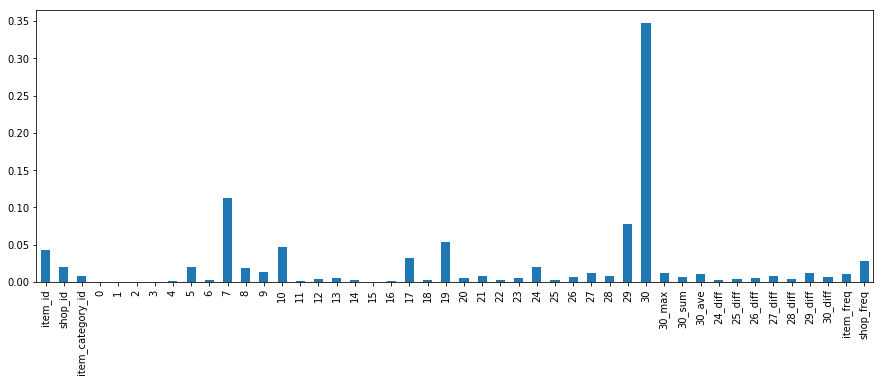

In [127]:
pd.Series(index= x_tr_df.columns,data= rf.feature_importances_).plot(kind = 'bar')

#### Adding item and itcat frequencies

In [17]:
itcat_freq = by_month.groupby('item_category_id').size().rename('itcat_freq') 

In [130]:
scrt = []
for i in val_months:
    print('validating on month %d' % (i+1))
    [x_tr_df, x_tr, x_tr_pred_df, x_tr_pred] = max_sum_average(tr_index_init=0, tr_index=i, max_num=1, ave_num=1, 
                                                               sum_num=1, expand = False)
    x_te = by_month[i]
    x_te_pred = create_y(i)
    
    req_cols = ['item_id', 'shop_id']
    req_cols_diff = np.arange((i-7),(i))
    req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
    req_cols.extend(req_cols_diff)
    x_tr_df = x_tr_df.merge(diff_df.loc[:,req_cols], on = ['item_id', 'shop_id'])
    x_tr_df = x_tr_df.join(item_freq, on = 'item_id')
    x_tr_df = x_tr_df.join(itcat_freq, on = 'item_category_id')
    
    req_cols_pred = ['item_id', 'shop_id']
    req_cols_diff = np.arange((i-6),(i+1))
    req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
    req_cols_pred.extend(req_cols_diff)
    x_tr_pred_df = x_tr_pred_df.merge(diff_df.loc[:,req_cols_pred], on = ['item_id', 'shop_id'])
    x_tr_pred_df = x_tr_pred_df.join(item_freq, on = 'item_id')
    x_tr_pred_df = x_tr_pred_df.join(itcat_freq, on = 'item_category_id')
    
    print('shape of train', x_tr_df.shape)
    print('shape of validation', x_tr_pred_df.shape)
    rf = RandomForestRegressor(n_estimators = 50, n_jobs = -1)
    rf.fit(x_tr_df.values, x_te)
    pred = rf.predict(x_tr_pred_df.values)
    scrt.append(error(pred, x_te_pred.values.flatten()))
    print('validation error for month %d = %.5f' %(i, error(pred, x_te_pred.values.flatten())))

print('mean error: %.5f' % (np.mean(scrt)))

validating on month 28
shape of train (424124, 42)
shape of validation (111404, 42)
validation error for month 27 = 3.09471
validating on month 29
shape of train (424124, 43)
shape of validation (111404, 43)
validation error for month 28 = 1.31241
validating on month 30
shape of train (424124, 44)
shape of validation (111404, 44)
validation error for month 29 = 1.10462
validating on month 31
shape of train (424124, 45)
shape of validation (111404, 45)
validation error for month 30 = 1.05672
validating on month 32
shape of train (424124, 46)
shape of validation (111404, 46)
validation error for month 31 = 1.54293
mean error: 1.62228


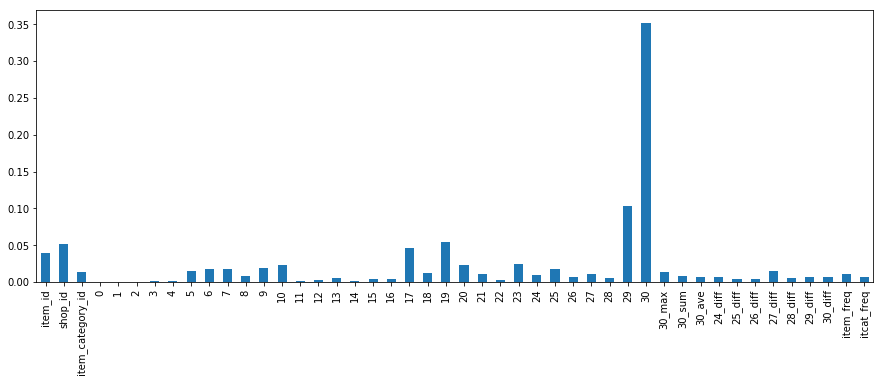

In [131]:
pd.Series(index= x_tr_df.columns,data= rf.feature_importances_).plot(kind = 'bar')

#### Add frequency of itcat with shop id

In [18]:
itcat_shop_freq = by_month.groupby(['item_category_id', 'shop_id']).size().rename('itcat_shop_freq')

In [151]:
scrt = []
for i in val_months:
    print('validating on month %d' % (i+1))
    [x_tr_df, x_tr, x_tr_pred_df, x_tr_pred] = max_sum_average(tr_index_init=0, tr_index=i, max_num=1, ave_num=1, 
                                                               sum_num=1, expand = False)
    x_te = by_month[i]
    x_te_pred = create_y(i)
    
    req_cols = ['item_id', 'shop_id']
    req_cols_diff = np.arange((i-7),(i))
    req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
    req_cols.extend(req_cols_diff)
    x_tr_df = x_tr_df.merge(diff_df.loc[:,req_cols], on = ['item_id', 'shop_id'])
    x_tr_df = x_tr_df.join(item_freq, on = 'item_id')
    x_tr_df = x_tr_df.join(itcat_shop_freq, on = ['item_category_id', 'shop_id'])
    
    req_cols_pred = ['item_id', 'shop_id']
    req_cols_diff = np.arange((i-6),(i+1))
    req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
    req_cols_pred.extend(req_cols_diff)
    x_tr_pred_df = x_tr_pred_df.merge(diff_df.loc[:,req_cols_pred], on = ['item_id', 'shop_id'])
    x_tr_pred_df = x_tr_pred_df.join(item_freq, on = 'item_id')
    x_tr_pred_df = x_tr_pred_df.join(itcat_shop_freq, on = ['item_category_id', 'shop_id'])
    
    print('shape of train', x_tr_df.shape)
    print('shape of validation', x_tr_pred_df.shape)
    rf = RandomForestRegressor(n_estimators = 50, n_jobs = -1)
    rf.fit(x_tr_df.values, x_te)
    pred = rf.predict(x_tr_pred_df.values)
    scrt.append(error(pred, x_te_pred.values.flatten()))
    print('validation error for month %d = %.5f' %(i, error(pred, x_te_pred.values.flatten())))

print('mean error: %.5f' % (np.mean(scrt)))

validating on month 28
shape of train (424124, 42)
shape of validation (111404, 42)
validation error for month 27 = 3.01900
validating on month 29
shape of train (424124, 43)
shape of validation (111404, 43)
validation error for month 28 = 1.27754
validating on month 30
shape of train (424124, 44)
shape of validation (111404, 44)
validation error for month 29 = 1.04458
validating on month 31
shape of train (424124, 45)
shape of validation (111404, 45)
validation error for month 30 = 1.07330
validating on month 32
shape of train (424124, 46)
shape of validation (111404, 46)
validation error for month 31 = 1.66558
mean error: 1.61600


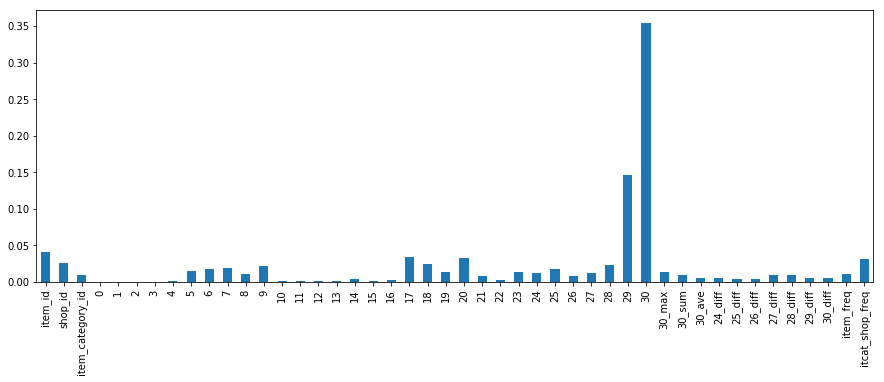

In [152]:
pd.Series(index= x_tr_df.columns,data= rf.feature_importances_).plot(kind = 'bar')

In [65]:
scrt = []
for i in val_months:
    print('validating on month %d' % (i+1))
    [x_tr_df, x_tr, x_tr_pred_df, x_tr_pred] = max_sum_average(tr_index_init=0, tr_index=i, max_num=1, ave_num=1, 
                                                               sum_num=1, expand = False)
    x_te = by_month[i]
    x_te_pred = create_y(i)
    
    req_cols = ['item_id', 'shop_id']
    req_cols_diff = np.arange((i-7),(i))
    req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
    req_cols.extend(req_cols_diff)
    x_tr_df = x_tr_df.merge(diff_df.loc[:,req_cols], on = ['item_id', 'shop_id'])
    x_tr_df = x_tr_df.join(item_freq, on = 'item_id')
    x_tr_df = x_tr_df.join(itcat_shop_freq, on = ['item_category_id', 'shop_id'])
    
    req_cols_pred = ['item_id', 'shop_id']
    req_cols_diff = np.arange((i-6),(i+1))
    req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
    req_cols_pred.extend(req_cols_diff)
    x_tr_pred_df = x_tr_pred_df.merge(diff_df.loc[:,req_cols_pred], on = ['item_id', 'shop_id'])
    x_tr_pred_df = x_tr_pred_df.join(item_freq, on = 'item_id')
    x_tr_pred_df = x_tr_pred_df.join(itcat_shop_freq, on = ['item_category_id', 'shop_id'])
    
    print('shape of train', x_tr_df.shape)
    print('shape of validation', x_tr_pred_df.shape)
    cat_features = [0,1,2]
    cat_rf = CatBoostRegressor(learning_rate=0.1, iterations = 3000, l2_leaf_reg = 50, depth = 2, 
                               one_hot_max_size=2, metric_period=1500, rsm = 1, thread_count = 4)
    cat_rf.fit(x_tr_df, x_te, cat_features = cat_features, early_stopping_rounds=200) #eval_set=(x_tr_pred_df, x_te_pred), 
    pred = cat_rf.predict(x_tr_pred_df.values)
    scrt.append(error(pred, x_te_pred.values.flatten()))
    print('validation error for month %d = %.5f' %(i, error(pred, x_te_pred.values.flatten())))

print('mean error: %.5f' % (np.mean(scrt)))

validating on month 28
shape of train (424124, 42)
shape of validation (111404, 42)
0:	learn: 3.5691077	total: 110ms	remaining: 5m 29s
1500:	learn: 2.7078127	total: 2m 6s	remaining: 2m 6s
2999:	learn: 2.6617280	total: 4m 10s	remaining: 0us
validation error for month 27 = 4.42482
validating on month 29
shape of train (424124, 43)
shape of validation (111404, 43)
0:	learn: 2.8296853	total: 108ms	remaining: 5m 23s
1500:	learn: 1.5450102	total: 2m 1s	remaining: 2m 1s
2999:	learn: 1.4800530	total: 4m 5s	remaining: 0us
validation error for month 28 = 1.54806
validating on month 30
shape of train (424124, 44)
shape of validation (111404, 44)
0:	learn: 1.6904847	total: 117ms	remaining: 5m 50s
1500:	learn: 0.6462259	total: 2m 12s	remaining: 2m 12s
2999:	learn: 0.6122299	total: 4m 30s	remaining: 0us
validation error for month 29 = 1.00866
validating on month 31
shape of train (424124, 45)
shape of validation (111404, 45)
0:	learn: 1.5664691	total: 114ms	remaining: 5m 41s
1500:	learn: 0.5684659	t

### Add ewms 

In [165]:
ewm26 = by_month.loc[:,months].ewm(span = 26, axis = 1).mean()
ewm12 = by_month.loc[:,months].ewm(span = 12, axis = 1).mean()

In [169]:
macd = ewm26-ewm12
sig = macd.ewm(span = 9, axis = 1).mean()
macd = pd.concat([by_month.loc[:,['item_id', 'shop_id']], macd.add_suffix('_macd')], axis = 1)
macd_sig = pd.concat([macd, sig.add_suffix('_sig')], axis = 1)

In [174]:
scrt = []
for i in val_months:
    print('validating on month %d' % (i+1))
    [x_tr_df, x_tr, x_tr_pred_df, x_tr_pred] = max_sum_average(tr_index_init=0, tr_index=i, max_num=1, ave_num=1, 
                                                               sum_num=1, expand = False)
    x_te = by_month[i]
    x_te_pred = create_y(i)
    
    req_cols = ['item_id', 'shop_id']
    req_cols_diff = np.arange((i-7),(i))
    req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
    req_cols.extend(req_cols_diff)
    x_tr_df = x_tr_df.merge(diff_df.loc[:,req_cols], on = ['item_id', 'shop_id'])
    x_tr_df = x_tr_df.join(item_freq, on = 'item_id')
    x_tr_df = x_tr_df.join(itcat_shop_freq, on = ['item_category_id', 'shop_id'])
    
    ewms_cols = np.arange(i-12, i)
    ewms_suff = ['macd', 'sig']
    ewms_cols_suff = ['{}_{}'.format(a,b) for b in ewms_suff for a in ewms_cols]
    ewms_train_cols = ['item_id', 'shop_id']
    ewms_train_cols.extend(ewms_cols_suff)
    x_tr_df = x_tr_df.merge(macd_sig.loc[:,ewms_train_cols], on = ['item_id', 'shop_id'])
    
    req_cols_pred = ['item_id', 'shop_id']
    req_cols_diff = np.arange((i-6),(i+1))
    req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
    req_cols_pred.extend(req_cols_diff)
    x_tr_pred_df = x_tr_pred_df.merge(diff_df.loc[:,req_cols_pred], on = ['item_id', 'shop_id'])
    x_tr_pred_df = x_tr_pred_df.join(item_freq, on = 'item_id')
    x_tr_pred_df = x_tr_pred_df.join(itcat_shop_freq, on = ['item_category_id', 'shop_id'])
    
    ewms_cols_pred = np.arange(i-11, i+1)
    ewms_cols_suff_pred = ['{}_{}'.format(a,b) for b in ewms_suff for a in ewms_cols_pred]
    ewms_val_cols = ['item_id', 'shop_id']
    ewms_val_cols.extend(ewms_cols_suff_pred)
    x_tr_pred_df = x_tr_pred_df.merge(macd_sig.loc[:,ewms_val_cols], on = ['item_id', 'shop_id'])
    
    print('shape of train', x_tr_df.shape)
    print('shape of validation', x_tr_pred_df.shape)
    rf = RandomForestRegressor(n_estimators = 50, n_jobs = -1)
    rf.fit(x_tr_df.values, x_te)
    pred = rf.predict(x_tr_pred_df.values)
    scrt.append(error(pred, x_te_pred.values.flatten()))
    print('validation error for month %d = %.5f' %(i, error(pred, x_te_pred.values.flatten())))

print('mean error: %.5f' % (np.mean(scrt)))

validating on month 28
shape of train (424124, 66)
shape of validation (111404, 66)
validation error for month 27 = 4.22190
validating on month 29
shape of train (424124, 67)
shape of validation (111404, 67)
validation error for month 28 = 1.51579
validating on month 30
shape of train (424124, 68)
shape of validation (111404, 68)
validation error for month 29 = 1.00313
validating on month 31
shape of train (424124, 69)
shape of validation (111404, 69)
validation error for month 30 = 1.05398
validating on month 32
shape of train (424124, 70)
shape of validation (111404, 70)
validation error for month 31 = 1.52411
mean error: 1.86378


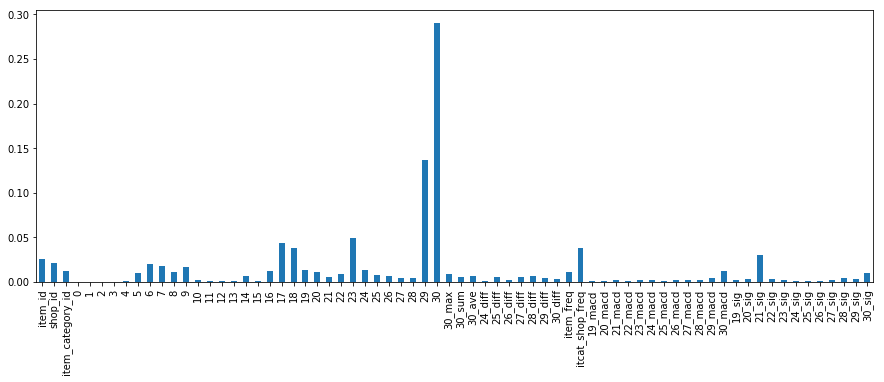

In [175]:
pd.Series(index= x_tr_df.columns,data= rf.feature_importances_).plot(kind = 'bar')

#### Decreasing the number of ewms

In [176]:
scrt = []
for i in val_months:
    print('validating on month %d' % (i+1))
    [x_tr_df, x_tr, x_tr_pred_df, x_tr_pred] = max_sum_average(tr_index_init=0, tr_index=i, max_num=1, ave_num=1, 
                                                               sum_num=1, expand = False)
    x_te = by_month[i]
    x_te_pred = create_y(i)
    
    req_cols = ['item_id', 'shop_id']
    req_cols_diff = np.arange((i-7),(i))
    req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
    req_cols.extend(req_cols_diff)
    x_tr_df = x_tr_df.merge(diff_df.loc[:,req_cols], on = ['item_id', 'shop_id'])
    x_tr_df = x_tr_df.join(item_freq, on = 'item_id')
    x_tr_df = x_tr_df.join(itcat_shop_freq, on = ['item_category_id', 'shop_id'])
    
    ewms_cols = np.arange(i-1, i)
    ewms_suff = ['macd', 'sig']
    ewms_cols_suff = ['{}_{}'.format(a,b) for b in ewms_suff for a in ewms_cols]
    ewms_train_cols = ['item_id', 'shop_id']
    ewms_train_cols.extend(ewms_cols_suff)
    x_tr_df = x_tr_df.merge(macd_sig.loc[:,ewms_train_cols], on = ['item_id', 'shop_id'])
    
    req_cols_pred = ['item_id', 'shop_id']
    req_cols_diff = np.arange((i-6),(i+1))
    req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
    req_cols_pred.extend(req_cols_diff)
    x_tr_pred_df = x_tr_pred_df.merge(diff_df.loc[:,req_cols_pred], on = ['item_id', 'shop_id'])
    x_tr_pred_df = x_tr_pred_df.join(item_freq, on = 'item_id')
    x_tr_pred_df = x_tr_pred_df.join(itcat_shop_freq, on = ['item_category_id', 'shop_id'])
    
    ewms_cols_pred = np.arange(i, i+1)
    ewms_cols_suff_pred = ['{}_{}'.format(a,b) for b in ewms_suff for a in ewms_cols_pred]
    ewms_val_cols = ['item_id', 'shop_id']
    ewms_val_cols.extend(ewms_cols_suff_pred)
    x_tr_pred_df = x_tr_pred_df.merge(macd_sig.loc[:,ewms_val_cols], on = ['item_id', 'shop_id'])
    
    print('shape of train', x_tr_df.shape)
    print('shape of validation', x_tr_pred_df.shape)
    rf = RandomForestRegressor(n_estimators = 50, n_jobs = -1)
    rf.fit(x_tr_df.values, x_te)
    pred = rf.predict(x_tr_pred_df.values)
    scrt.append(error(pred, x_te_pred.values.flatten()))
    print('validation error for month %d = %.5f' %(i, error(pred, x_te_pred.values.flatten())))

print('mean error: %.5f' % (np.mean(scrt)))

validating on month 28
shape of train (424124, 44)
shape of validation (111404, 44)
validation error for month 27 = 4.10388
validating on month 29
shape of train (424124, 45)
shape of validation (111404, 45)
validation error for month 28 = 1.40765
validating on month 30
shape of train (424124, 46)
shape of validation (111404, 46)
validation error for month 29 = 1.05018
validating on month 31
shape of train (424124, 47)
shape of validation (111404, 47)
validation error for month 30 = 1.05115
validating on month 32
shape of train (424124, 48)
shape of validation (111404, 48)
validation error for month 31 = 1.56391
mean error: 1.83535


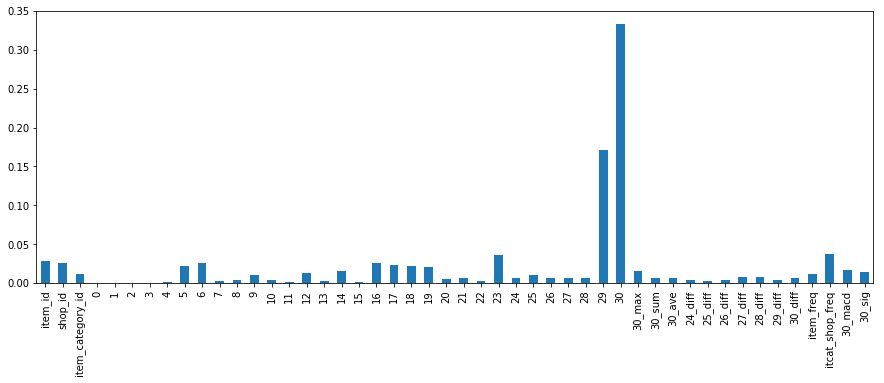

In [177]:
pd.Series(index= x_tr_df.columns,data= rf.feature_importances_).plot(kind = 'bar')

In [178]:
scrt = []
for i in val_months:
    print('validating on month %d' % (i+1))
    [x_tr_df, x_tr, x_tr_pred_df, x_tr_pred] = max_sum_average(tr_index_init=0, tr_index=i, max_num=1, ave_num=1, 
                                                               sum_num=1, expand = False)
    x_te = by_month[i]
    x_te_pred = create_y(i)
    
    req_cols = ['item_id', 'shop_id']
    req_cols_diff = np.arange((i-7),(i))
    req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
    req_cols.extend(req_cols_diff)
    x_tr_df = x_tr_df.merge(diff_df.loc[:,req_cols], on = ['item_id', 'shop_id'])
    x_tr_df = x_tr_df.join(item_freq, on = 'item_id')
    x_tr_df = x_tr_df.join(itcat_shop_freq, on = ['item_category_id', 'shop_id'])
    
    ewms_cols = np.arange(i-1, i)
    ewms_suff = ['macd', 'sig']
    ewms_cols_suff = ['{}_{}'.format(a,b) for b in ewms_suff for a in ewms_cols]
    ewms_train_cols = ['item_id', 'shop_id']
    ewms_train_cols.extend(ewms_cols_suff)
    x_tr_df = x_tr_df.merge(macd_sig.loc[:,ewms_train_cols], on = ['item_id', 'shop_id'])
    
    req_cols_pred = ['item_id', 'shop_id']
    req_cols_diff = np.arange((i-6),(i+1))
    req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
    req_cols_pred.extend(req_cols_diff)
    x_tr_pred_df = x_tr_pred_df.merge(diff_df.loc[:,req_cols_pred], on = ['item_id', 'shop_id'])
    x_tr_pred_df = x_tr_pred_df.join(item_freq, on = 'item_id')
    x_tr_pred_df = x_tr_pred_df.join(itcat_shop_freq, on = ['item_category_id', 'shop_id'])
    
    ewms_cols_pred = np.arange(i, i+1)
    ewms_cols_suff_pred = ['{}_{}'.format(a,b) for b in ewms_suff for a in ewms_cols_pred]
    ewms_val_cols = ['item_id', 'shop_id']
    ewms_val_cols.extend(ewms_cols_suff_pred)
    x_tr_pred_df = x_tr_pred_df.merge(macd_sig.loc[:,ewms_val_cols], on = ['item_id', 'shop_id'])
    
    print('shape of train', x_tr_df.shape)
    print('shape of validation', x_tr_pred_df.shape)
    cat_features = [0,1,2]
    cat_rf = CatBoostRegressor(learning_rate=0.1, iterations = 3000, l2_leaf_reg = 50, depth = 2, 
                               one_hot_max_size=2, metric_period=1500, rsm = 1)
    cat_rf.fit(x_tr_df, x_te, cat_features = cat_features, early_stopping_rounds=200) #eval_set=(x_tr_pred_df, x_te_pred), 
    pred = cat_rf.predict(x_tr_pred_df.values)
    scrt.append(error(pred, x_te_pred.values.flatten()))
    print('----> validation error for month %d = %.5f' %(i, error(pred, x_te_pred.values.flatten())))

print('----> mean error: %.5f' % (np.mean(scrt)))

validating on month 28
shape of train (424124, 44)
shape of validation (111404, 44)
0:	learn: 3.5726163	total: 302ms	remaining: 15m 4s
1500:	learn: 2.8002971	total: 4m 26s	remaining: 4m 25s
2999:	learn: 2.7340997	total: 8m 32s	remaining: 0us
----> validation error for month 27 = 3.76688
validating on month 29
shape of train (424124, 45)
shape of validation (111404, 45)
0:	learn: 2.8286883	total: 236ms	remaining: 11m 48s
1500:	learn: 1.5543526	total: 4m 17s	remaining: 4m 17s
2999:	learn: 1.4796660	total: 8m 33s	remaining: 0us
----> validation error for month 28 = 1.58788
validating on month 30
shape of train (424124, 46)
shape of validation (111404, 46)
0:	learn: 1.6812805	total: 216ms	remaining: 10m 47s
1500:	learn: 0.6516019	total: 4m 24s	remaining: 4m 24s
2999:	learn: 0.6169473	total: 8m 58s	remaining: 0us
----> validation error for month 29 = 0.99402
validating on month 31
shape of train (424124, 47)
shape of validation (111404, 47)
0:	learn: 1.5608231	total: 216ms	remaining: 10m 47

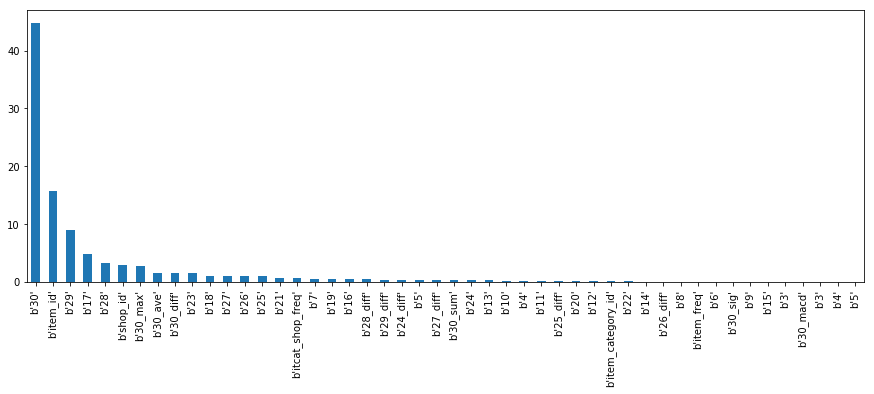

In [182]:
features = [i[0] for i in cat_rf.get_feature_importance(prettified=True)]
imp = [i[1] for i in cat_rf.get_feature_importance(prettified=True)]
pd.Series(data=imp, index = features).plot(kind = 'bar')

### Adding price of items last month

In [19]:
price = sales_train.groupby(['date_block_num', 'item_id', 'shop_id']).mean()['item_price']
price_month = sales_train.groupby(['item_id', 'shop_id']).mean()['item_price'].rename('item_price')

In [69]:
scrt = []
for i in val_months:
    print('validating on month %d' % (i+1))
    [x_tr_df, x_tr, x_tr_pred_df, x_tr_pred] = max_sum_average(tr_index_init=0, tr_index=i, max_num=1, ave_num=1, 
                                                               sum_num=1, expand = False)
    x_te = by_month[i]
    x_te_pred = create_y(i)
    
    req_cols = ['item_id', 'shop_id']
    req_cols_diff = np.arange((i-7),(i))
    req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
    req_cols.extend(req_cols_diff)
    x_tr_df = x_tr_df.merge(diff_df.loc[:,req_cols], on = ['item_id', 'shop_id'])
    x_tr_df = x_tr_df.join(item_freq, on = 'item_id')
    x_tr_df = x_tr_df.join(itcat_shop_freq, on = ['item_category_id', 'shop_id'])
    x_tr_df['item_price'] = x_tr_df.join(price.loc[i-1], 
                                         on = ['item_id', 'shop_id']).set_index(['item_id',
                                                                                 'shop_id'])['item_price'].fillna(price_month, 
                                                                                                                  axis = 0).values
    req_cols_pred = ['item_id', 'shop_id']
    req_cols_diff = np.arange((i-6),(i+1))
    req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
    req_cols_pred.extend(req_cols_diff)
    x_tr_pred_df = x_tr_pred_df.merge(diff_df.loc[:,req_cols_pred], on = ['item_id', 'shop_id'])
    x_tr_pred_df = x_tr_pred_df.join(item_freq, on = 'item_id')
    x_tr_pred_df = x_tr_pred_df.join(itcat_shop_freq, on = ['item_category_id', 'shop_id'])
    x_tr_pred_df['item_price'] = x_tr_pred_df.join(price.loc[i], 
                                         on = ['item_id', 'shop_id']).set_index(['item_id', 
                                                                                 'shop_id'])['item_price'].fillna(price_month, 
                                                                                                                  axis = 0).values
    
    print('shape of train', x_tr_df.shape)
    print('shape of validation', x_tr_pred_df.shape)
    cat_features = [0,1,2]
    cat_rf = CatBoostRegressor(learning_rate=0.1, iterations = 3000, l2_leaf_reg = 50, depth = 2, 
                               one_hot_max_size=2, metric_period=1500, rsm = 1, thread_count = 4)
    cat_rf.fit(x_tr_df, x_te, cat_features = cat_features, early_stopping_rounds=200) #eval_set=(x_tr_pred_df, x_te_pred), 
    pred = cat_rf.predict(x_tr_pred_df.values)
    scrt.append(error(pred, x_te_pred.values.flatten()))
    print('---->validation error for month %d = %.5f' %(i, error(pred, x_te_pred.values.flatten())))

print('---->mean error: %.5f' % (np.mean(scrt)))

validating on month 28
shape of train (424124, 43)
shape of validation (111404, 43)
0:	learn: 3.5744259	total: 130ms	remaining: 6m 30s
1500:	learn: 2.6731451	total: 2m 20s	remaining: 2m 20s
2999:	learn: 2.5567481	total: 4m 29s	remaining: 0us
---->validation error for month 27 = 3.54911
validating on month 29
shape of train (424124, 44)
shape of validation (111404, 44)
0:	learn: 2.8298861	total: 118ms	remaining: 5m 54s
1500:	learn: 1.4876693	total: 2m 11s	remaining: 2m 11s
2999:	learn: 1.3886175	total: 4m 22s	remaining: 0us
---->validation error for month 28 = 1.66417
validating on month 30
shape of train (424124, 45)
shape of validation (111404, 45)
0:	learn: 1.6888511	total: 122ms	remaining: 6m 6s
1500:	learn: 0.6462739	total: 2m 16s	remaining: 2m 16s
2999:	learn: 0.6133666	total: 4m 37s	remaining: 0us
---->validation error for month 29 = 1.03462
validating on month 31
shape of train (424124, 46)
shape of validation (111404, 46)
0:	learn: 1.5668920	total: 118ms	remaining: 5m 53s
1500:

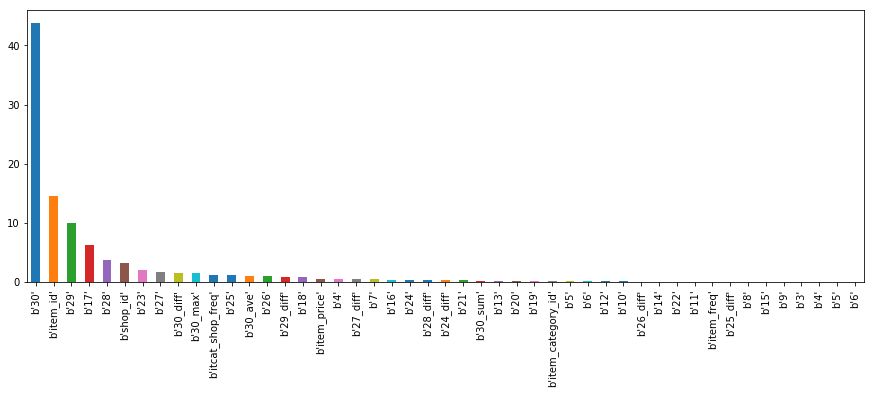

In [72]:
features = [i[0] for i in cat_rf.get_feature_importance(prettified=True)]
imp = [i[1] for i in cat_rf.get_feature_importance(prettified=True)]
pd.Series(data=imp, index = features).plot(kind = 'bar')

### Adding correlations

In [20]:
by_month_itcat = by_month.groupby('item_category_id').sum(axis=0).loc[:,months]
by_month_itcat_corr = by_month_itcat.T.corr().add_suffix('_itcatcorr')
by_month_shopid = by_month.groupby('shop_id').sum(axis=0).loc[:,months]
by_month_shopid_corr = by_month_shopid.T.corr().add_suffix('_shopcorr')

In [23]:
scrt = []
for i in np.arange(31,32):
    print('validating on month %d' % (i+1))
    [x_tr_df, x_tr, x_tr_pred_df, x_tr_pred] = max_sum_average(tr_index_init=0, tr_index=i, max_num=1, ave_num=1, 
                                                               sum_num=1, expand = False)
    x_te = by_month[i]
    x_te_pred = create_y(i)
    
    req_cols = ['item_id', 'shop_id']
    req_cols_diff = np.arange((i-7),(i))
    req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
    req_cols.extend(req_cols_diff)
    x_tr_df = x_tr_df.merge(diff_df.loc[:,req_cols], on = ['item_id', 'shop_id'])
    x_tr_df = x_tr_df.join(item_freq, on = 'item_id')
    x_tr_df = x_tr_df.join(itcat_shop_freq, on = ['item_category_id', 'shop_id'])
    x_tr_df['item_price'] = x_tr_df.join(price.loc[i-1], 
                                         on = ['item_id', 'shop_id']).set_index(['item_id',
                                                                                 'shop_id'])['item_price'].fillna(price_month, 
                                                                                                                  axis = 0).values
    x_tr_df = x_tr_df.join(by_month_itcat_corr, on = 'item_category_id')
    x_tr_df = x_tr_df.join(by_month_shopid_corr, on = 'shop_id')
    
    req_cols_pred = ['item_id', 'shop_id']
    req_cols_diff = np.arange((i-6),(i+1))
    req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
    req_cols_pred.extend(req_cols_diff)
    x_tr_pred_df = x_tr_pred_df.merge(diff_df.loc[:,req_cols_pred], on = ['item_id', 'shop_id'])
    x_tr_pred_df = x_tr_pred_df.join(item_freq, on = 'item_id')
    x_tr_pred_df = x_tr_pred_df.join(itcat_shop_freq, on = ['item_category_id', 'shop_id'])
    x_tr_pred_df['item_price'] = x_tr_pred_df.join(price.loc[i], 
                                         on = ['item_id', 'shop_id']).set_index(['item_id', 
                                                                                 'shop_id'])['item_price'].fillna(price_month, 
                                                                                                                  axis = 0).values
    x_tr_pred_df = x_tr_pred_df.join(by_month_itcat_corr, on = 'item_category_id')
    x_tr_pred_df = x_tr_pred_df.join(by_month_shopid_corr, on = 'shop_id')
    
    print('shape of train', x_tr_df.shape)
    print('shape of validation', x_tr_pred_df.shape)
    cat_features = [0,1,2]
    cat_rf = CatBoostRegressor(learning_rate=0.1, iterations = 3000, l2_leaf_reg = 50, depth = 2, 
                               one_hot_max_size=2, metric_period=1500, rsm = 1, thread_count = 4)
    cat_rf.fit(x_tr_df, x_te, cat_features = cat_features, early_stopping_rounds=200) #eval_set=(x_tr_pred_df, x_te_pred), 
    pred = cat_rf.predict(x_tr_pred_df.values)
    scrt.append(error(pred, x_te_pred.values.flatten()))
    print('---->validation error for month %d = %.5f' %(i, error(pred, x_te_pred.values.flatten())))

print('---->mean error: %.5f' % (np.mean(scrt)))

validating on month 32
shape of train (424124, 191)
shape of validation (111404, 191)
0:	learn: 1.5804679	total: 336ms	remaining: 16m 46s
1500:	learn: 0.6303822	total: 4m	remaining: 4m
2999:	learn: 0.5766882	total: 8m 9s	remaining: 0us
---->validation error for month 31 = 1.53661
---->mean error: 1.53661


In [24]:
cat_rf.save_model('cat_model_32')

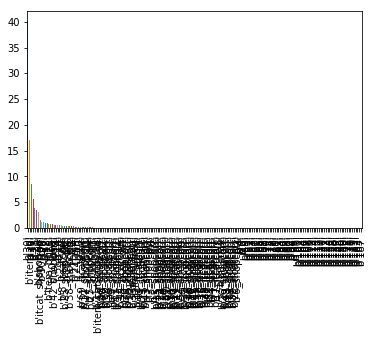

In [25]:
features = [i[0] for i in cat_rf.get_feature_importance(prettified=True)]
imp = [i[1] for i in cat_rf.get_feature_importance(prettified=True)]
pd.Series(data=imp, index = features).plot(kind = 'bar')

In [26]:
len([i[0] for i in cat_rf.get_feature_importance(prettified=True) if i[1]>0 ])

120

In [27]:
len(cat_rf.feature_names_)

120

### Selecting only important features

In [28]:
imp_feat = [i.decode("utf-8") for i in cat_rf.feature_names_]
itcat_feat = [i for i in imp_feat if '_itcatcorr' in i]
shop_feat = [i for i in imp_feat if '_shopcorr' in i]

In [67]:
scrt = []
for i in val_months:
    print('validating on month %d' % (i+1))
    [x_tr_df, x_tr, x_tr_pred_df, x_tr_pred] = max_sum_average(tr_index_init=0, tr_index=i, max_num=1, ave_num=1, 
                                                               sum_num=1, expand = False)
    x_te = by_month[i]
    x_te_pred = create_y(i)
    
    req_cols = ['item_id', 'shop_id']
    req_cols_diff = np.arange((i-7),(i))
    req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
    req_cols.extend(req_cols_diff)
    x_tr_df = x_tr_df.merge(diff_df.loc[:,req_cols], on = ['item_id', 'shop_id'])
    x_tr_df = x_tr_df.join(item_freq, on = 'item_id')
    x_tr_df = x_tr_df.join(itcat_shop_freq, on = ['item_category_id', 'shop_id'])
    x_tr_df['item_price'] = x_tr_df.join(price.loc[i-1], 
                                         on = ['item_id', 'shop_id']).set_index(['item_id',
                                                                                 'shop_id'])['item_price'].fillna(price_month, 
                                                                                                                  axis = 0).values
    x_tr_df = x_tr_df.join(by_month_itcat_corr[itcat_feat], on = 'item_category_id')
    x_tr_df = x_tr_df.join(by_month_shopid_corr[shop_feat], on = 'shop_id')
    
    req_cols_pred = ['item_id', 'shop_id']
    req_cols_diff = np.arange((i-6),(i+1))
    req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
    req_cols_pred.extend(req_cols_diff)
    x_tr_pred_df = x_tr_pred_df.merge(diff_df.loc[:,req_cols_pred], on = ['item_id', 'shop_id'])
    x_tr_pred_df = x_tr_pred_df.join(item_freq, on = 'item_id')
    x_tr_pred_df = x_tr_pred_df.join(itcat_shop_freq, on = ['item_category_id', 'shop_id'])
    x_tr_pred_df['item_price'] = x_tr_pred_df.join(price.loc[i], 
                                         on = ['item_id', 'shop_id']).set_index(['item_id', 
                                                                                 'shop_id'])['item_price'].fillna(price_month, 
                                                                                                                  axis = 0).values
    x_tr_pred_df = x_tr_pred_df.join(by_month_itcat_corr[itcat_feat], on = 'item_category_id')
    x_tr_pred_df = x_tr_pred_df.join(by_month_shopid_corr[shop_feat], on = 'shop_id')
    
    print('shape of train', x_tr_df.shape)
    print('shape of validation', x_tr_pred_df.shape)
    rf = RandomForestRegressor(n_estimators = 50, n_jobs = -1)
    rf.fit(x_tr_df.values, x_te)
    pred = rf.predict(x_tr_pred_df.values)
    scrt.append(error(pred, x_te_pred.values.flatten()))
    print('---->validation error for month %d = %.5f' %(i, error(pred, x_te_pred.values.flatten())))

print('---->mean error: %.5f' % (np.mean(scrt)))

validating on month 28
shape of train (424124, 115)
shape of validation (111404, 115)
---->validation error for month 27 = 3.19288
validating on month 29
shape of train (424124, 116)
shape of validation (111404, 116)
---->validation error for month 28 = 1.32871
validating on month 30
shape of train (424124, 117)
shape of validation (111404, 117)
---->validation error for month 29 = 0.99989
validating on month 31
shape of train (424124, 118)
shape of validation (111404, 118)
---->validation error for month 30 = 1.04726
validating on month 32
shape of train (424124, 119)
shape of validation (111404, 119)
---->validation error for month 31 = 1.53405
---->mean error: 1.62056


In [64]:
scrt = []
for i in val_months:
    print('validating on month %d' % (i+1))
    [x_tr_df, x_tr, x_tr_pred_df, x_tr_pred] = max_sum_average(tr_index_init=0, tr_index=i, max_num=1, ave_num=1, 
                                                               sum_num=1, expand = False)
    x_te = by_month[i]
    x_te_pred = create_y(i)
    
    req_cols = ['item_id', 'shop_id']
    req_cols_diff = np.arange((i-7),(i))
    req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
    req_cols.extend(req_cols_diff)
    x_tr_df = x_tr_df.merge(diff_df.loc[:,req_cols], on = ['item_id', 'shop_id'])
    x_tr_df = x_tr_df.join(item_freq, on = 'item_id')
    x_tr_df = x_tr_df.join(itcat_shop_freq, on = ['item_category_id', 'shop_id'])
    x_tr_df['item_price'] = x_tr_df.join(price.loc[i-1], 
                                         on = ['item_id', 'shop_id']).set_index(['item_id',
                                                                                 'shop_id'])['item_price'].fillna(price_month, 
                                                                                                                  axis = 0).values
    x_tr_df = x_tr_df.join(by_month_itcat_corr[itcat_feat], on = 'item_category_id')
    x_tr_df = x_tr_df.join(by_month_shopid_corr[shop_feat], on = 'shop_id')
    
    req_cols_pred = ['item_id', 'shop_id']
    req_cols_diff = np.arange((i-6),(i+1))
    req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
    req_cols_pred.extend(req_cols_diff)
    x_tr_pred_df = x_tr_pred_df.merge(diff_df.loc[:,req_cols_pred], on = ['item_id', 'shop_id'])
    x_tr_pred_df = x_tr_pred_df.join(item_freq, on = 'item_id')
    x_tr_pred_df = x_tr_pred_df.join(itcat_shop_freq, on = ['item_category_id', 'shop_id'])
    x_tr_pred_df['item_price'] = x_tr_pred_df.join(price.loc[i], 
                                         on = ['item_id', 'shop_id']).set_index(['item_id', 
                                                                                 'shop_id'])['item_price'].fillna(price_month, 
                                                                                                                  axis = 0).values
    x_tr_pred_df = x_tr_pred_df.join(by_month_itcat_corr[itcat_feat], on = 'item_category_id')
    x_tr_pred_df = x_tr_pred_df.join(by_month_shopid_corr[shop_feat], on = 'shop_id')
    
    print('shape of train', x_tr_df.shape)
    print('shape of validation', x_tr_pred_df.shape)
    cat_features = [0,1,2]
    cat_rf = CatBoostRegressor(learning_rate=0.1, iterations = 3000, l2_leaf_reg = 50, depth = 2, 
                               one_hot_max_size=2, metric_period=1500, rsm = 1, thread_count = 4)
    cat_rf.fit(x_tr_df, x_te, cat_features = cat_features, early_stopping_rounds=200) #eval_set=(x_tr_pred_df, x_te_pred), 
    pred = cat_rf.predict(x_tr_pred_df.values)
    scrt.append(error(pred, x_te_pred.values.flatten()))
    print('---->validation error for month %d = %.5f' %(i, error(pred, x_te_pred.values.flatten())))

print('---->mean error: %.5f' % (np.mean(scrt)))

validating on month 28
shape of train (424124, 115)
shape of validation (111404, 115)
0:	learn: 3.5707639	total: 181ms	remaining: 9m 3s
1500:	learn: 2.6514869	total: 2m 58s	remaining: 2m 58s
2999:	learn: 2.5814642	total: 5m 52s	remaining: 0us
---->validation error for month 27 = 3.68211
validating on month 29
shape of train (424124, 116)
shape of validation (111404, 116)
0:	learn: 2.8265243	total: 151ms	remaining: 7m 34s
1500:	learn: 1.6102186	total: 2m 49s	remaining: 2m 49s
2999:	learn: 1.5140650	total: 5m 39s	remaining: 0us
---->validation error for month 28 = 1.64259
validating on month 30
shape of train (424124, 117)
shape of validation (111404, 117)
0:	learn: 1.6969467	total: 148ms	remaining: 7m 23s
1500:	learn: 0.6462566	total: 2m 58s	remaining: 2m 58s
2999:	learn: 0.6119000	total: 6m 6s	remaining: 0us
---->validation error for month 29 = 0.98919
validating on month 31
shape of train (424124, 118)
shape of validation (111404, 118)
0:	learn: 1.5658954	total: 260ms	remaining: 12m 5

### Tune the parameters

#### Using eval set for optimum number of trees

In [68]:
scrt = []
for i in val_months:
    print('validating on month %d' % (i+1))
    [x_tr_df, x_tr, x_tr_pred_df, x_tr_pred] = max_sum_average(tr_index_init=0, tr_index=i, max_num=1, ave_num=1, 
                                                               sum_num=1, expand = False)
    x_te = by_month[i]
    x_te_pred = create_y(i)
    
    req_cols = ['item_id', 'shop_id']
    req_cols_diff = np.arange((i-7),(i))
    req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
    req_cols.extend(req_cols_diff)
    x_tr_df = x_tr_df.merge(diff_df.loc[:,req_cols], on = ['item_id', 'shop_id'])
    x_tr_df = x_tr_df.join(item_freq, on = 'item_id')
    x_tr_df = x_tr_df.join(itcat_shop_freq, on = ['item_category_id', 'shop_id'])
    x_tr_df['item_price'] = x_tr_df.join(price.loc[i-1], 
                                         on = ['item_id', 'shop_id']).set_index(['item_id',
                                                                                 'shop_id'])['item_price'].fillna(price_month, 
                                                                                                                  axis = 0).values
    x_tr_df = x_tr_df.join(by_month_itcat_corr[itcat_feat], on = 'item_category_id')
    x_tr_df = x_tr_df.join(by_month_shopid_corr[shop_feat], on = 'shop_id')
    
    req_cols_pred = ['item_id', 'shop_id']
    req_cols_diff = np.arange((i-6),(i+1))
    req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
    req_cols_pred.extend(req_cols_diff)
    x_tr_pred_df = x_tr_pred_df.merge(diff_df.loc[:,req_cols_pred], on = ['item_id', 'shop_id'])
    x_tr_pred_df = x_tr_pred_df.join(item_freq, on = 'item_id')
    x_tr_pred_df = x_tr_pred_df.join(itcat_shop_freq, on = ['item_category_id', 'shop_id'])
    x_tr_pred_df['item_price'] = x_tr_pred_df.join(price.loc[i], 
                                         on = ['item_id', 'shop_id']).set_index(['item_id', 
                                                                                 'shop_id'])['item_price'].fillna(price_month, 
                                                                                                                  axis = 0).values
    x_tr_pred_df = x_tr_pred_df.join(by_month_itcat_corr[itcat_feat], on = 'item_category_id')
    x_tr_pred_df = x_tr_pred_df.join(by_month_shopid_corr[shop_feat], on = 'shop_id')
    
    print('shape of train', x_tr_df.shape)
    print('shape of validation', x_tr_pred_df.shape)
    cat_features = [0,1,2]
    cat_rf = CatBoostRegressor(learning_rate=0.1, iterations = 3000, l2_leaf_reg = 50, depth = 2, 
                               one_hot_max_size=2, metric_period=500, rsm = 1, thread_count = 4)
    cat_rf.fit(x_tr_df, x_te, cat_features = cat_features, early_stopping_rounds=200, eval_set=(x_tr_pred_df, x_te_pred)) 
    pred = cat_rf.predict(x_tr_pred_df.values)
    scrt.append(error(pred, x_te_pred.values.flatten()))
    print('---->validation error for month %d = %.5f' %(i, error(pred, x_te_pred.values.flatten())))

print('---->mean error: %.5f' % (np.mean(scrt)))

validating on month 28
shape of train (424124, 115)
shape of validation (111404, 115)
0:	learn: 3.5742193	test: 5.2976284	best: 5.2976284 (0)	total: 158ms	remaining: 7m 54s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 4.617120096
bestIteration = 251

Shrink model to first 252 iterations.
---->validation error for month 27 = 3.32975
validating on month 29
shape of train (424124, 116)
shape of validation (111404, 116)
0:	learn: 2.8296853	test: 3.1580877	best: 3.1580877 (0)	total: 237ms	remaining: 11m 49s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 1.770375538
bestIteration = 178

Shrink model to first 179 iterations.
---->validation error for month 28 = 1.27675
validating on month 30
shape of train (424124, 117)
shape of validation (111404, 117)
0:	learn: 1.6854448	test: 2.9674385	best: 2.9674385 (0)	total: 151ms	remaining: 7m 31s
500:	learn: 0.7172018	test: 1.3937344	best: 1.3936063 (490)	total: 59.8s	remaining: 4m 58s
Stopped by overfitting 

In [74]:
scrt = []
for i in range(31,32):
    print('validating on month %d' % (i+1))
    [x_tr_df, x_tr, x_tr_pred_df, x_tr_pred] = max_sum_average(tr_index_init=0, tr_index=i, max_num=1, ave_num=1, 
                                                               sum_num=1, expand = False)
    x_te = by_month[i]
    x_te_pred = create_y(i)
    
    req_cols = ['item_id', 'shop_id']
    req_cols_diff = np.arange((i-7),(i))
    req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
    req_cols.extend(req_cols_diff)
    x_tr_df = x_tr_df.merge(diff_df.loc[:,req_cols], on = ['item_id', 'shop_id'])
    x_tr_df = x_tr_df.join(item_freq, on = 'item_id')
    x_tr_df = x_tr_df.join(itcat_shop_freq, on = ['item_category_id', 'shop_id'])
    x_tr_df['item_price'] = x_tr_df.join(price.loc[i-1], 
                                         on = ['item_id', 'shop_id']).set_index(['item_id',
                                                                                 'shop_id'])['item_price'].fillna(price_month, 
                                                                                                                  axis = 0).values
    x_tr_df = x_tr_df.join(by_month_itcat_corr[itcat_feat], on = 'item_category_id')
    x_tr_df = x_tr_df.join(by_month_shopid_corr[shop_feat], on = 'shop_id')
    
    req_cols_pred = ['item_id', 'shop_id']
    req_cols_diff = np.arange((i-6),(i+1))
    req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
    req_cols_pred.extend(req_cols_diff)
    x_tr_pred_df = x_tr_pred_df.merge(diff_df.loc[:,req_cols_pred], on = ['item_id', 'shop_id'])
    x_tr_pred_df = x_tr_pred_df.join(item_freq, on = 'item_id')
    x_tr_pred_df = x_tr_pred_df.join(itcat_shop_freq, on = ['item_category_id', 'shop_id'])
    x_tr_pred_df['item_price'] = x_tr_pred_df.join(price.loc[i], 
                                         on = ['item_id', 'shop_id']).set_index(['item_id', 
                                                                                 'shop_id'])['item_price'].fillna(price_month, 
                                                                                                                  axis = 0).values
    x_tr_pred_df = x_tr_pred_df.join(by_month_itcat_corr[itcat_feat], on = 'item_category_id')
    x_tr_pred_df = x_tr_pred_df.join(by_month_shopid_corr[shop_feat], on = 'shop_id')
    
    print('shape of train', x_tr_df.shape)
    print('shape of validation', x_tr_pred_df.shape)
    cat_features = [0,1,2]
    cat_rf = CatBoostRegressor(iterations = 3000, l2_leaf_reg = 50, depth = 2, 
                               one_hot_max_size=2, rsm = 1, thread_count = 4)
    cat_rf.fit(x_tr_df, x_te, cat_features = cat_features, early_stopping_rounds=200, eval_set=(x_tr_pred_df, x_te_pred), 
               plot = True, logging_level = 'Silent') 
    pred = cat_rf.predict(x_tr_pred_df.values)
    scrt.append(error(pred, x_te_pred.values.flatten()))
    print('---->validation error for month %d = %.5f' %(i, error(pred, x_te_pred.values.flatten())))

print('---->mean error: %.5f' % (np.mean(scrt)))

validating on month 32
shape of train (424124, 119)
shape of validation (111404, 119)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

---->validation error for month 31 = 1.54173
---->mean error: 1.54173


In [22]:
import hyperopt
from hyperopt import hp
from hyperopt.pyll.stochastic import sample
import seaborn as sns
from timeit import default_timer as timer
from numpy.random import RandomState
from hyperopt import STATUS_OK
import csv

In [150]:
x_train_list = []
x_valid_list = []
x_train_y = []
x_valid_y = []
m = [27, 31]
for i in m:
    [x_tr_df, x_tr, x_tr_pred_df, x_tr_pred] = max_sum_average(tr_index_init=0, tr_index=i, max_num=1, ave_num=1, 
                                                               sum_num=1, expand = False)
    x_te = by_month[i]
    x_te_pred = create_y(i)
    
    req_cols = ['item_id', 'shop_id']
    req_cols_diff = np.arange((i-7),(i))
    req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
    req_cols.extend(req_cols_diff)
    x_tr_df = x_tr_df.merge(diff_df.loc[:,req_cols], on = ['item_id', 'shop_id'])
    x_tr_df = x_tr_df.join(item_freq, on = 'item_id')
    x_tr_df = x_tr_df.join(itcat_shop_freq, on = ['item_category_id', 'shop_id'])
    x_tr_df['item_price'] = x_tr_df.join(price.loc[i-1], 
                                         on = ['item_id', 'shop_id']).set_index(['item_id',
                                                                                 'shop_id'])['item_price'].fillna(price_month, 
                                                                                                                  axis = 0).values
    x_tr_df = x_tr_df.join(by_month_itcat_corr[itcat_feat], on = 'item_category_id')
    x_tr_df = x_tr_df.join(by_month_shopid_corr[shop_feat], on = 'shop_id')
    
    req_cols_pred = ['item_id', 'shop_id']
    req_cols_diff = np.arange((i-6),(i+1))
    req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
    req_cols_pred.extend(req_cols_diff)
    x_tr_pred_df = x_tr_pred_df.merge(diff_df.loc[:,req_cols_pred], on = ['item_id', 'shop_id'])
    x_tr_pred_df = x_tr_pred_df.join(item_freq, on = 'item_id')
    x_tr_pred_df = x_tr_pred_df.join(itcat_shop_freq, on = ['item_category_id', 'shop_id'])
    x_tr_pred_df['item_price'] = x_tr_pred_df.join(price.loc[i], 
                                         on = ['item_id', 'shop_id']).set_index(['item_id', 
                                                                                 'shop_id'])['item_price'].fillna(price_month, 
                                                                                                                  axis = 0).values
    x_tr_pred_df = x_tr_pred_df.join(by_month_itcat_corr[itcat_feat], on = 'item_category_id')
    x_tr_pred_df = x_tr_pred_df.join(by_month_shopid_corr[shop_feat], on = 'shop_id')
    
    x_train_list.append(x_tr_df)
    x_valid_list.append(x_tr_pred_df)
    x_train_y.append(x_te)
    x_valid_y.append(x_te_pred)

In [180]:
def objective(params):
    global ITERATION
    ITERATION +=1
    print('ITERATION: %d' %(ITERATION))
    model = CatBoostRegressor(iterations = 3000, l2_leaf_reg=params['l2_leaf_reg'], learning_rate = params['learning_rate'],
                             rsm = params['rsm'], random_seed = 42, thread_count = 4, 
                              depth = params['depth'])
    start = timer()
    srtc = []
    for i in range(len(x_train_list)):
        model.fit(x_train_list[i], x_train_y[i], eval_set = (x_valid_list[i], x_valid_y[i]), cat_features = cat_features, 
                  early_stopping_rounds=200, logging_level = 'Silent')
        pred = model.predict(x_tr_pred_df.values)
        srtc.append(error(pred, x_valid_y[i].values.flatten()))
    train_time = timer()-start
    loss = np.mean(srtc)
    print('loss: %.5f' %(loss))
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([ITERATION, loss, params, train_time])
    return {'iteration': ITERATION, 'loss': loss, 'params': params,   
            'train_time': train_time, 'status': STATUS_OK}

In [178]:
out_file = 'cat_trials.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['iteration', 'loss', 'params', 'n_estimators', 'train_time'])
of_connection.close()

In [127]:
params_space = {
    'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', np.log(1), np.log(100), 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
    'rsm': 1 - hp.loguniform('rsm',np.log(0.05) , np.log(1)),
    'depth': hp.quniform('depth', 1, 10, 1)
}

In [126]:
sample(params_space)

{'depth': 4.0,
 'l2_leaf_reg': 33.0,
 'learning_rate': 0.10369812375455405,
 'rsm': 0.6809104511051831}

In [128]:
learning_rate_dist = []
l2_leaf_dist = []
rsm_dist = []
depth_dist = []
# Draw 10000 samples from the learning rate domain
for _ in range(10000):
    dic = sample(params_space)
    learning_rate_dist.append(dic['learning_rate'])
    l2_leaf_dist.append(dic['l2_leaf_reg'])
    rsm_dist.append(dic['rsm'])
    depth_dist.append(dic['depth'])

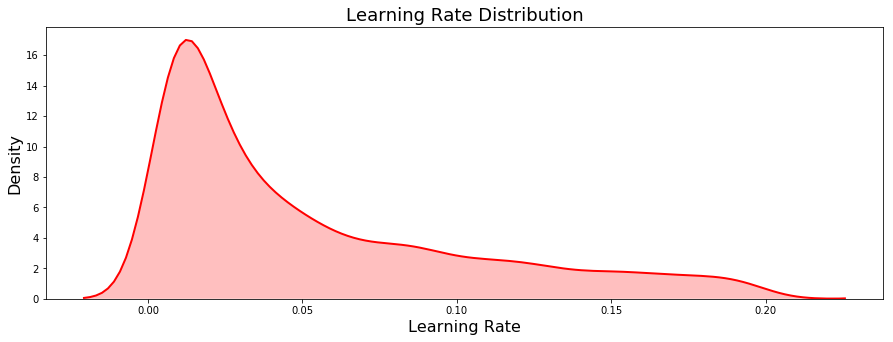

In [98]:
sns.kdeplot(learning_rate_dist, color = 'red', linewidth = 2, shade = True);
plt.title('Learning Rate Distribution', size = 18); 
plt.xlabel('Learning Rate', size = 16); plt.ylabel('Density', size = 16);

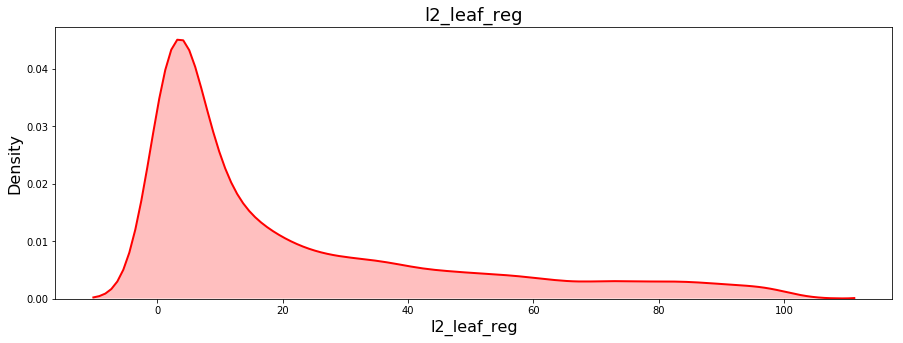

In [99]:
sns.kdeplot(l2_leaf_dist, color = 'red', linewidth = 2, shade = True);
plt.title('l2_leaf_reg', size = 18); 
plt.xlabel('l2_leaf_reg', size = 16); plt.ylabel('Density', size = 16);

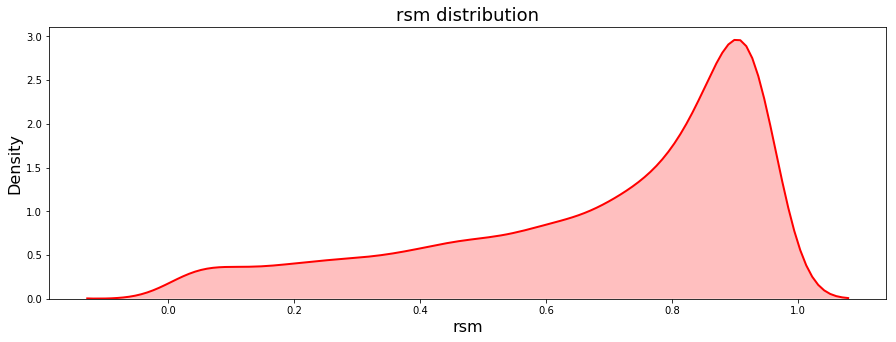

In [102]:
sns.kdeplot(rsm_dist, color = 'red', linewidth = 2, shade = True);
plt.title('rsm distribution', size = 18); 
plt.xlabel('rsm', size = 16); plt.ylabel('Density', size = 16);

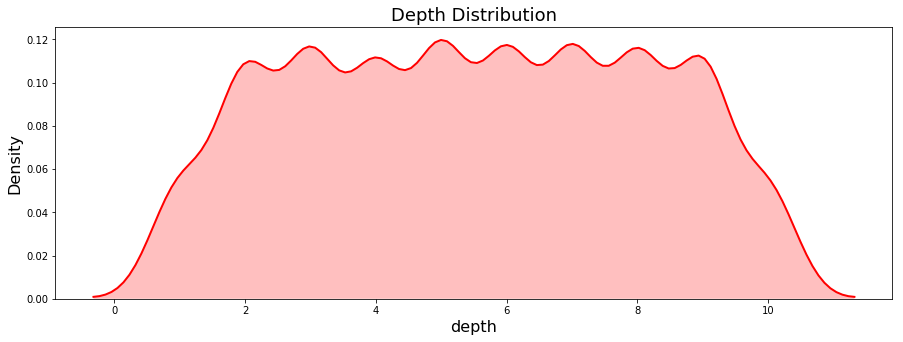

In [129]:
sns.kdeplot(depth_dist, color = 'red', linewidth = 2, shade = True);
plt.title('Depth Distribution', size = 18); 
plt.xlabel('depth', size = 16); plt.ylabel('Density', size = 16);

In [181]:
trials = hyperopt.Trials()
global  ITERATION
ITERATION = 0
best = hyperopt.fmin(
    objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=30,
    trials=trials,
    rstate=RandomState(123)
)

ITERATION: 1
loss: 2.60963
ITERATION: 2
loss: 2.51506
ITERATION: 3
loss: 3.98522
ITERATION: 4
loss: 2.60876
ITERATION: 5
loss: 2.64283
ITERATION: 6
loss: 2.48338
ITERATION: 7
loss: 2.69539
ITERATION: 8
loss: 2.77067
ITERATION: 9
loss: 2.55959
ITERATION: 10
loss: 2.71694
ITERATION: 11
loss: 2.59070
ITERATION: 12
loss: 2.51151
ITERATION: 13
loss: 2.58848
ITERATION: 14
loss: 2.83862
ITERATION: 15
loss: 2.54662
ITERATION: 16
loss: 2.38809
ITERATION: 17
loss: 2.98524
ITERATION: 18
loss: 2.69527
ITERATION: 19
loss: 2.69363
ITERATION: 20
loss: 2.78304
ITERATION: 21
loss: 2.55264
ITERATION: 22
loss: 2.40920
ITERATION: 23
loss: 2.70634
ITERATION: 24
loss: 2.41165
ITERATION: 25
loss: 2.41261
ITERATION: 26
loss: 2.53499
ITERATION: 27
loss: 2.58088
ITERATION: 28
loss: 2.65570
ITERATION: 29
loss: 2.55563
ITERATION: 30
loss: 3.51715


In [32]:
results = pd.read_csv('cat_trials.csv')

In [37]:
results.drop('train_time', inplace = True, axis = 1)

In [41]:
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.rename({'n_estimators': 'train_time'}, axis = 1, inplace = True)
results.head()

,iteration,loss,params,n_estimators
0,16,2.388094,"{'depth': 2.0, 'l2_leaf_reg': 2.0, 'learning_r...",236.234264
1,22,2.409197,"{'depth': 3.0, 'l2_leaf_reg': 2.0, 'learning_r...",327.016699
2,24,2.411652,"{'depth': 3.0, 'l2_leaf_reg': 3.0, 'learning_r...",618.454360
3,25,2.412611,"{'depth': 3.0, 'l2_leaf_reg': 4.0, 'learning_r...",525.824635
4,6,2.483375,"{'depth': 7.0, 'l2_leaf_reg': 1.0, 'learning_r...",414.490229


In [47]:
best_params = results.loc[0,'params']

In [51]:
best_params

"{'depth': 2.0, 'l2_leaf_reg': 2.0, 'learning_rate': 0.01381114981103704, 'rsm': 0.5840261003971998}"

In [53]:
import ast

# Convert from a string to a dictionary
best_params = ast.literal_eval(results.loc[0, 'params'])

In [54]:
i = 32
[x_tr_df, x_tr, x_tr_pred_df, x_tr_pred] = max_sum_average(tr_index_init=0, tr_index=i, max_num=1, ave_num=1, 
                                                               sum_num=1, expand = False)
x_te = by_month[i]
x_te_pred = create_y(i)
req_cols = ['item_id', 'shop_id']
req_cols_diff = np.arange((i-7),(i))
req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
req_cols.extend(req_cols_diff)
x_tr_df = x_tr_df.merge(diff_df.loc[:,req_cols], on = ['item_id', 'shop_id'])
x_tr_df = x_tr_df.join(item_freq, on = 'item_id')
x_tr_df = x_tr_df.join(itcat_shop_freq, on = ['item_category_id', 'shop_id'])
x_tr_df['item_price'] = x_tr_df.join(price.loc[i-1], 
                                     on = ['item_id', 'shop_id']).set_index(['item_id',
                                                                             'shop_id'])['item_price'].fillna(price_month, 
                                                                                                              axis = 0).values
x_tr_df = x_tr_df.join(by_month_itcat_corr[itcat_feat], on = 'item_category_id')
x_tr_df = x_tr_df.join(by_month_shopid_corr[shop_feat], on = 'shop_id')
    
req_cols_pred = ['item_id', 'shop_id']
req_cols_diff = np.arange((i-6),(i+1))
req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
req_cols_pred.extend(req_cols_diff)
x_tr_pred_df = x_tr_pred_df.merge(diff_df.loc[:,req_cols_pred], on = ['item_id', 'shop_id'])
x_tr_pred_df = x_tr_pred_df.join(item_freq, on = 'item_id')
x_tr_pred_df = x_tr_pred_df.join(itcat_shop_freq, on = ['item_category_id', 'shop_id'])
x_tr_pred_df['item_price'] = x_tr_pred_df.join(price.loc[i], 
                                     on = ['item_id', 'shop_id']).set_index(['item_id', 
                                                                             'shop_id'])['item_price'].fillna(price_month, 
                                                                                                              axis = 0).values
x_tr_pred_df = x_tr_pred_df.join(by_month_itcat_corr[itcat_feat], on = 'item_category_id')
x_tr_pred_df = x_tr_pred_df.join(by_month_shopid_corr[shop_feat], on = 'shop_id')

print('shape of train', x_tr_df.shape)
print('shape of test', x_tr_pred_df.shape)
cat_features = [0,1,2]
cat_rf = CatBoostRegressor(iterations = 3000, l2_leaf_reg=best_params['l2_leaf_reg'], learning_rate = best_params['learning_rate'], 
                           rsm = best_params['rsm'], random_seed = 42, thread_count = 4, 
                           depth = best_params['depth'])
cat_rf.fit(x_tr_df, x_te, cat_features = cat_features, 
           eval_set=(x_tr_pred_df, x_te_pred), early_stopping_rounds=200, logging_level = 'Silent', plot = True)
pred = cat_rf.predict(x_tr_pred_df.values)
print('test error',  error(pred, x_te_pred.values.flatten()))

shape of train (424124, 125)
shape of test (111404, 125)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

test error 4.681054189824201


In [56]:
opt_tree = cat_rf.tree_count_

### Finally predicting for month 34

In [70]:
i = 33
[x_tr_df, x_tr, x_tr_pred_df, x_tr_pred] = max_sum_average(tr_index_init=0, tr_index=i, max_num=1, ave_num=1, 
                                                               sum_num=1, expand = False)
x_te = by_month[i]
req_cols = ['item_id', 'shop_id']
req_cols_diff = np.arange((i-7),(i))
req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
req_cols.extend(req_cols_diff)
x_tr_df = x_tr_df.merge(diff_df.loc[:,req_cols], on = ['item_id', 'shop_id'])
x_tr_df = x_tr_df.join(item_freq, on = 'item_id')
x_tr_df = x_tr_df.join(itcat_shop_freq, on = ['item_category_id', 'shop_id'])
x_tr_df['item_price'] = x_tr_df.join(price.loc[i-1], 
                                     on = ['item_id', 'shop_id']).set_index(['item_id',
                                                                             'shop_id'])['item_price'].fillna(price_month, 
                                                                                                              axis = 0).values
x_tr_df = x_tr_df.join(by_month_itcat_corr[itcat_feat], on = 'item_category_id')
x_tr_df = x_tr_df.join(by_month_shopid_corr[shop_feat], on = 'shop_id')
    
req_cols_pred = ['item_id', 'shop_id']
req_cols_diff = np.arange((i-6),(i+1))
req_cols_diff = [str(i)+'_diff' for i in req_cols_diff]
req_cols_pred.extend(req_cols_diff)
x_tr_pred_df = x_tr_pred_df.merge(diff_df.loc[:,req_cols_pred], on = ['item_id', 'shop_id'])
x_tr_pred_df = x_tr_pred_df.join(item_freq, on = 'item_id')
x_tr_pred_df = x_tr_pred_df.join(itcat_shop_freq, on = ['item_category_id', 'shop_id'])
x_tr_pred_df['item_price'] = x_tr_pred_df.join(price.loc[i], 
                                     on = ['item_id', 'shop_id']).set_index(['item_id', 
                                                                             'shop_id'])['item_price'].fillna(price_month, 
                                                                                                              axis = 0).values
x_tr_pred_df = x_tr_pred_df.join(by_month_itcat_corr[itcat_feat], on = 'item_category_id')
x_tr_pred_df = x_tr_pred_df.join(by_month_shopid_corr[shop_feat], on = 'shop_id')

In [73]:
cat_features = [0,1,2]
cat_rf = CatBoostRegressor(iterations = opt_tree, l2_leaf_reg=best_params['l2_leaf_reg'], 
                           learning_rate = best_params['learning_rate'], 
                           rsm = best_params['rsm'], random_seed = 42, thread_count = 4, 
                           depth = best_params['depth'], metric_period = 50)
cat_rf.fit(x_tr_df, x_te, cat_features = cat_features)

0:	learn: 3.9928088	total: 123ms	remaining: 1m 51s
50:	learn: 3.2788255	total: 5.09s	remaining: 1m 25s
100:	learn: 2.7826981	total: 9.75s	remaining: 1m 17s
150:	learn: 2.4096017	total: 14.3s	remaining: 1m 11s
200:	learn: 2.1218619	total: 18.6s	remaining: 1m 5s
250:	learn: 1.9112042	total: 23.8s	remaining: 1m 1s
300:	learn: 1.7592469	total: 29.4s	remaining: 58.9s
350:	learn: 1.6429770	total: 34.5s	remaining: 54.4s
400:	learn: 1.5488282	total: 39.7s	remaining: 49.8s
450:	learn: 1.4758613	total: 44.2s	remaining: 44.4s
500:	learn: 1.4187689	total: 49.3s	remaining: 39.7s
550:	learn: 1.3735275	total: 55.3s	remaining: 35.4s
600:	learn: 1.3354942	total: 1m	remaining: 30.3s
650:	learn: 1.3021061	total: 1m 4s	remaining: 25.2s
700:	learn: 1.2726882	total: 1m 9s	remaining: 20.2s
750:	learn: 1.2498949	total: 1m 14s	remaining: 15.2s
800:	learn: 1.2292378	total: 1m 19s	remaining: 10.3s
850:	learn: 1.2105835	total: 1m 24s	remaining: 5.26s
900:	learn: 1.1942827	total: 1m 29s	remaining: 297ms
903:	learn

In [75]:
pred = cat_rf.predict(x_tr_pred_df.values)

In [76]:
pred

array([0.23235192, 0.73213787, 0.4102455 , ..., 0.08964843, 0.08964843,
       0.0896999 ])

In [79]:
create_submission_file(pred, 'catboost_final')